In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats
import seaborn as sns
import warnings
from sklearn.exceptions import DataConversionWarning
from pathlib import Path
from datetime import date
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
pd.set_option('display.html.table_schema', True)


Load data

In [3]:
%%bash
ls

AdaBoostRegressor DecisionTree vs real.png
AdaBoostRegressor RandomForest vs real.png
Bash.term
EDA_2019-12-01.ipynb
ElasticNetCV vs real.png
GradientBoostingRegressor vs real.png
cat_var_figs
cluster_map
eda
feat_imp_fig
feature_analysis.csv
num_var_figs
old
reg_models_eval
rfecv_model
rfecv_model_2019-12-29
test_values_dat102x_nov19_kWyIOM9.csv
train_labels_dat102x_nov19_DPetPH2.csv
train_values_dat102x_nov19_OL27nta.csv
tuned_gbr_271219


In [4]:
train_val=pd.read_csv("train_values_dat102x_nov19_OL27nta.csv", header=0)
train_lab=pd.read_csv("train_labels_dat102x_nov19_DPetPH2.csv", header=0)
test_val=pd.read_csv("test_values_dat102x_nov19_kWyIOM9.csv", header=0)

Set index to row_id.
Merge train values and labels with inner join based on row_id

In [5]:
train_lab.set_index('row_id',inplace=True)
train_val.set_index('row_id',inplace=True)
test_val.set_index('row_id',inplace=True)
train=pd.merge(train_val, train_lab, on='row_id')

Inspect the datataframes.
Check number of columns, number of values in each column, type of column.
Check results of merge operation

In [6]:
train_lab.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1562 entries, 0 to 1561
Data columns (total 1 columns):
gross_rent    1562 non-null int64
dtypes: int64(1)
memory usage: 24.4 KB


In [7]:
train_val.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1562 entries, 0 to 1561
Data columns (total 44 columns):
county_code                                   1562 non-null object
state                                         1562 non-null object
population                                    1562 non-null float64
renter_occupied_households                    1562 non-null float64
pct_renter_occupied                           1562 non-null float64
evictions                                     1235 non-null float64
rent_burden                                   1562 non-null float64
pct_white                                     1562 non-null float64
pct_af_am                                     1562 non-null float64
pct_hispanic                                  1562 non-null float64
pct_am_ind                                    1562 non-null float64
pct_asian                                     1562 non-null float64
pct_nh_pi                                     1562 non-null float64
pct_multipl

In [8]:
test_val.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1576 entries, 0 to 1575
Data columns (total 44 columns):
county_code                                   1576 non-null object
state                                         1576 non-null object
population                                    1576 non-null float64
renter_occupied_households                    1576 non-null float64
pct_renter_occupied                           1576 non-null float64
evictions                                     1263 non-null float64
rent_burden                                   1576 non-null float64
pct_white                                     1576 non-null float64
pct_af_am                                     1576 non-null float64
pct_hispanic                                  1576 non-null float64
pct_am_ind                                    1576 non-null float64
pct_asian                                     1576 non-null float64
pct_nh_pi                                     1576 non-null float64
pct_multipl

In [9]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1562 entries, 0 to 1561
Data columns (total 45 columns):
county_code                                   1562 non-null object
state                                         1562 non-null object
population                                    1562 non-null float64
renter_occupied_households                    1562 non-null float64
pct_renter_occupied                           1562 non-null float64
evictions                                     1235 non-null float64
rent_burden                                   1562 non-null float64
pct_white                                     1562 non-null float64
pct_af_am                                     1562 non-null float64
pct_hispanic                                  1562 non-null float64
pct_am_ind                                    1562 non-null float64
pct_asian                                     1562 non-null float64
pct_nh_pi                                     1562 non-null float64
pct_multipl

In [10]:
save_summary=False
eda_path=Path.cwd()/"eda"
try:
    eda_path.mkdir()
except:
    FileExistsError
if save_summary==True:
    train_lab.describe().T.to_excel(eda_path/"gross rent.xlsx")
    train_val.describe().T.to_excel(eda_path/"features.xlsx")
    test_val.describe().T.to_excel(eda_path/"test_features.xlsx")

homicides_per_100k has approximately 2/3 of missing data. Better to drop it.
Imputation will be necessary for other variables.

Select columns by type, and perform exploratory data analisis.
Correletion between numeric columns.
Distribution of label's values in categorical columns (rucc, urban_influence, economic_typology).
Check dist of gross_rent in state and county code.
County codes between training and validation set are different, drop them?

In [11]:
num_var=train.select_dtypes(include='number')
print(num_var.columns.values)
cat_var=train.select_dtypes(exclude='number')
print(cat_var.columns.values)

['population' 'renter_occupied_households' 'pct_renter_occupied'
 'evictions' 'rent_burden' 'pct_white' 'pct_af_am' 'pct_hispanic'
 'pct_am_ind' 'pct_asian' 'pct_nh_pi' 'pct_multiple' 'pct_other'
 'poverty_rate' 'pct_civilian_labor' 'pct_unemployment'
 'pct_uninsured_adults' 'pct_uninsured_children' 'pct_adult_obesity'
 'pct_adult_smoking' 'pct_diabetes' 'pct_low_birthweight'
 'pct_excessive_drinking' 'pct_physical_inactivity'
 'air_pollution_particulate_matter_value' 'homicides_per_100k'
 'motor_vehicle_crash_deaths_per_100k' 'heart_disease_mortality_per_100k'
 'pop_per_dentist' 'pop_per_primary_care_physician' 'pct_female'
 'pct_below_18_years_of_age' 'pct_aged_65_years_and_older'
 'pct_adults_less_than_a_high_school_diploma'
 'pct_adults_with_high_school_diploma' 'pct_adults_with_some_college'
 'pct_adults_bachelors_or_higher' 'birth_rate_per_1k' 'death_rate_per_1k'
 'gross_rent']


['county_code' 'state' 'rucc' 'urban_influence' 'economic_typology']


In [12]:
num_var.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1562 entries, 0 to 1561
Data columns (total 40 columns):
population                                    1562 non-null float64
renter_occupied_households                    1562 non-null float64
pct_renter_occupied                           1562 non-null float64
evictions                                     1235 non-null float64
rent_burden                                   1562 non-null float64
pct_white                                     1562 non-null float64
pct_af_am                                     1562 non-null float64
pct_hispanic                                  1562 non-null float64
pct_am_ind                                    1562 non-null float64
pct_asian                                     1562 non-null float64
pct_nh_pi                                     1562 non-null float64
pct_multiple                                  1562 non-null float64
pct_other                                     1562 non-null float64
poverty_r

/ext/anaconda-2019.03/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


<Figure size 432x288 with 0 Axes>

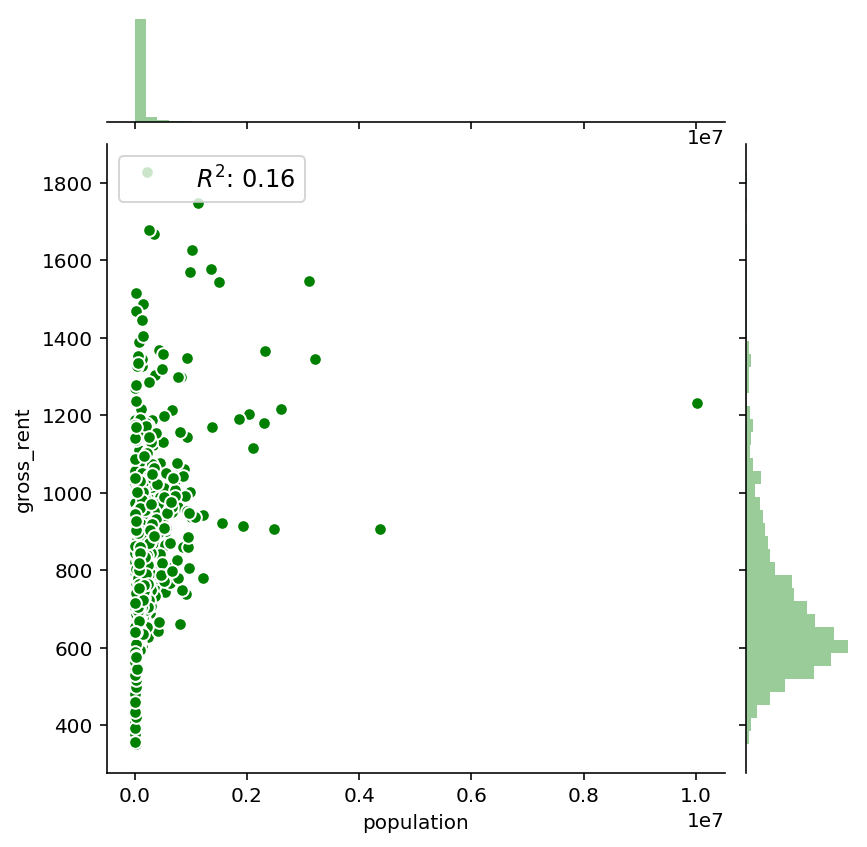

<Figure size 432x288 with 0 Axes>

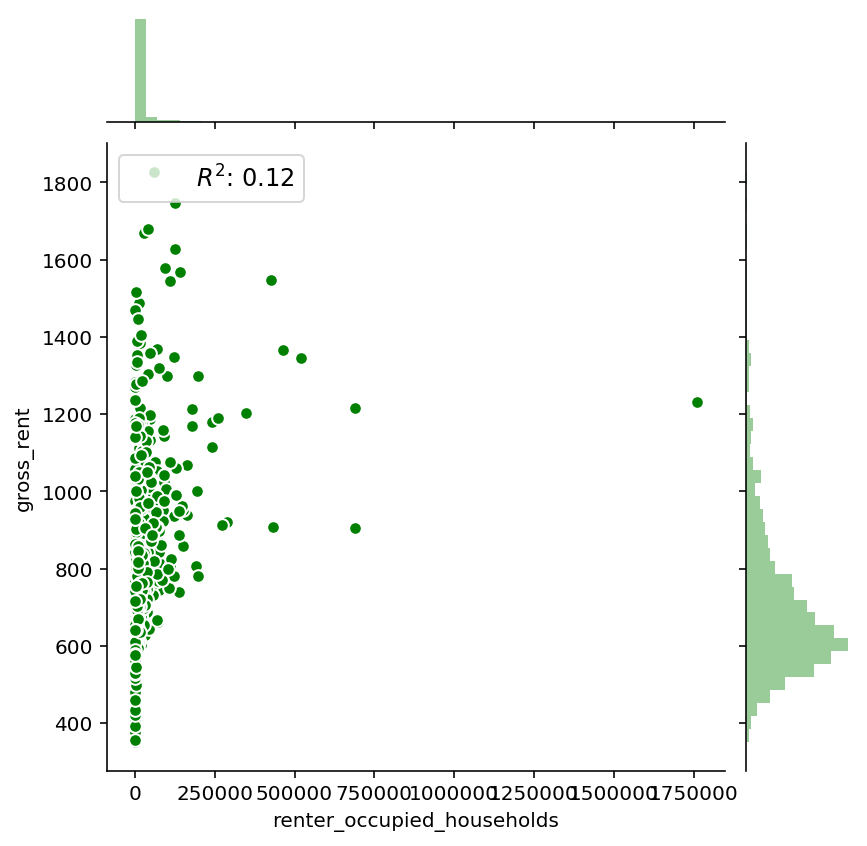

<Figure size 432x288 with 0 Axes>

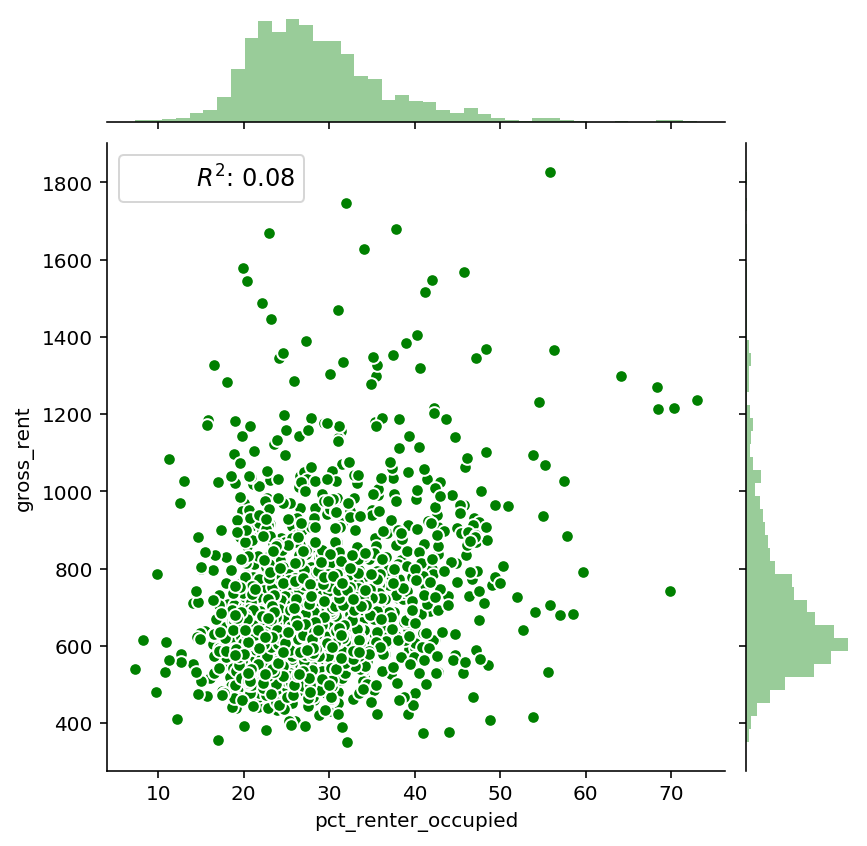

<Figure size 432x288 with 0 Axes>

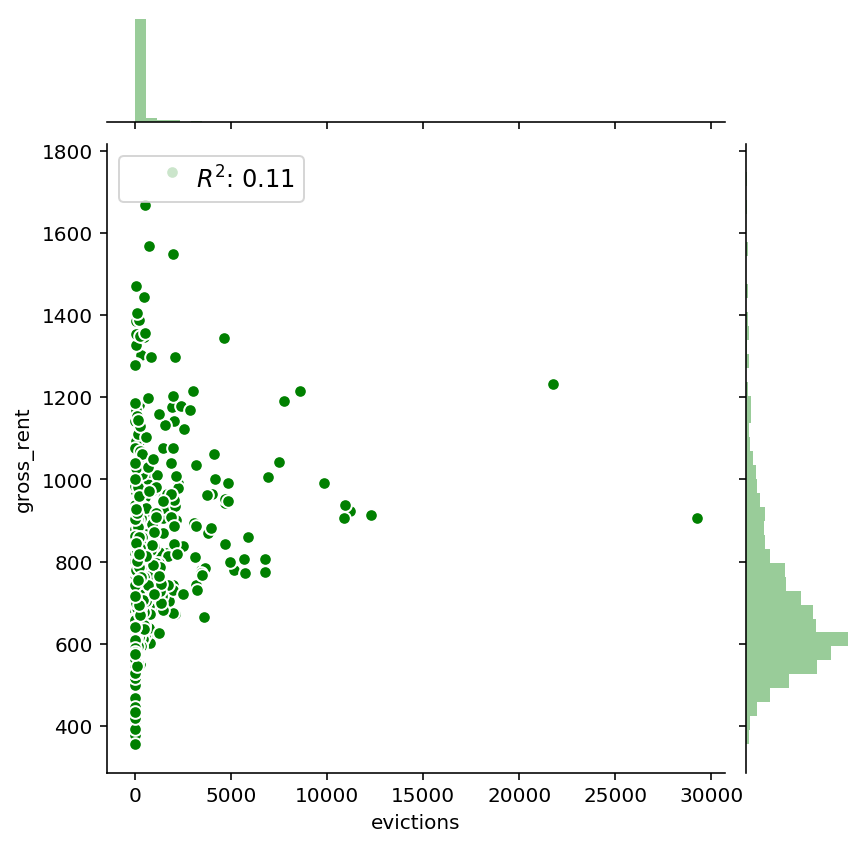

<Figure size 432x288 with 0 Axes>

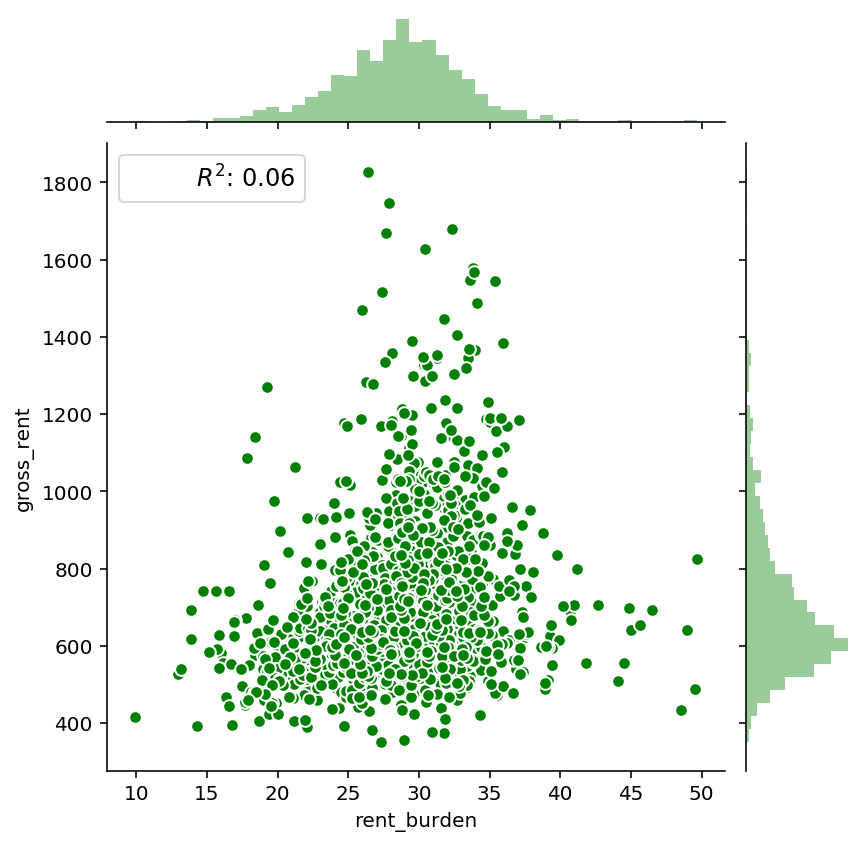

<Figure size 432x288 with 0 Axes>

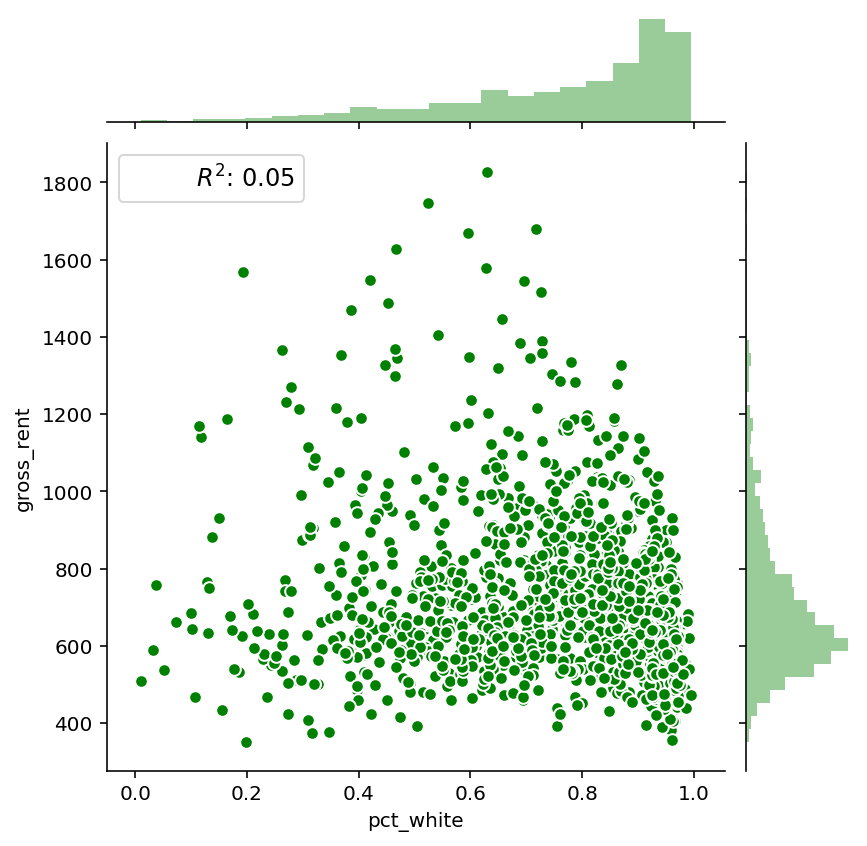

<Figure size 432x288 with 0 Axes>

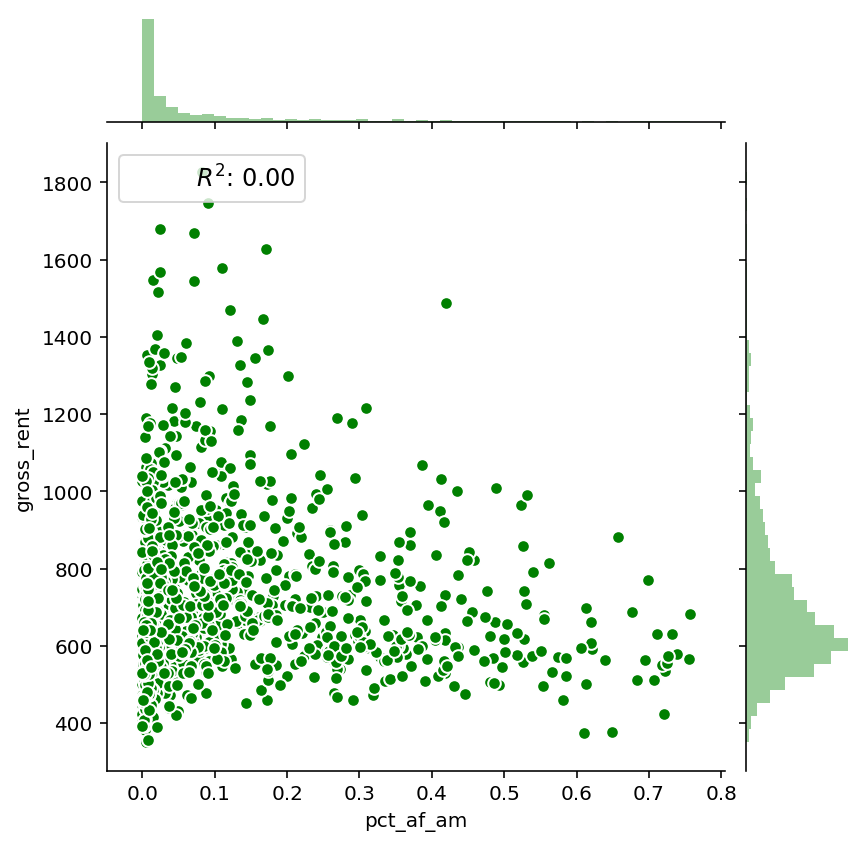

<Figure size 432x288 with 0 Axes>

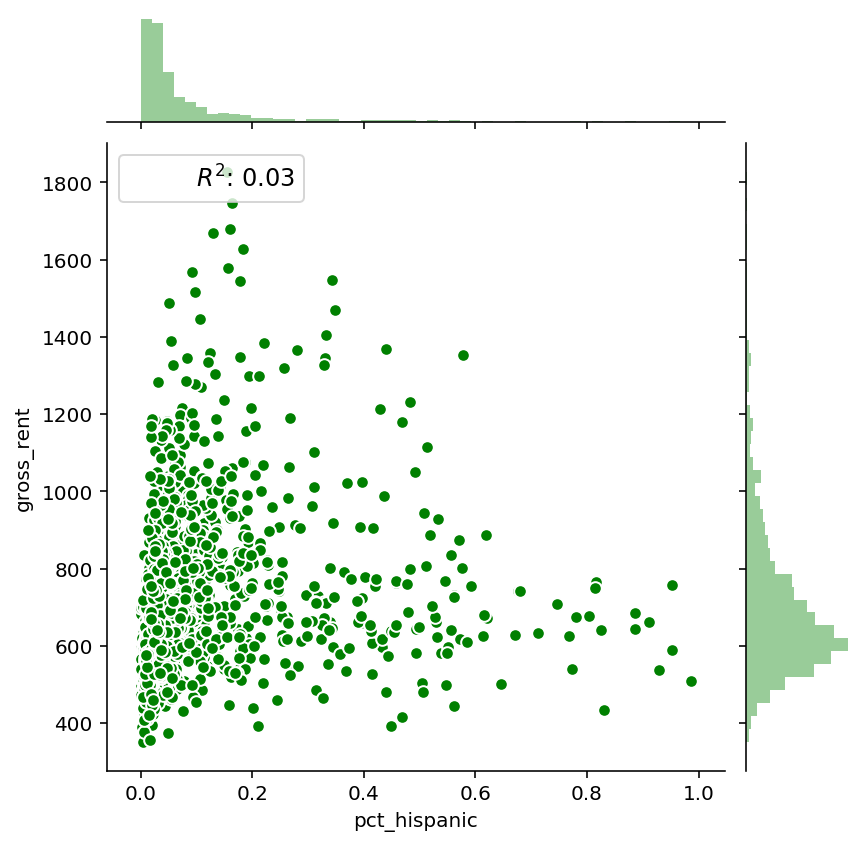

<Figure size 432x288 with 0 Axes>

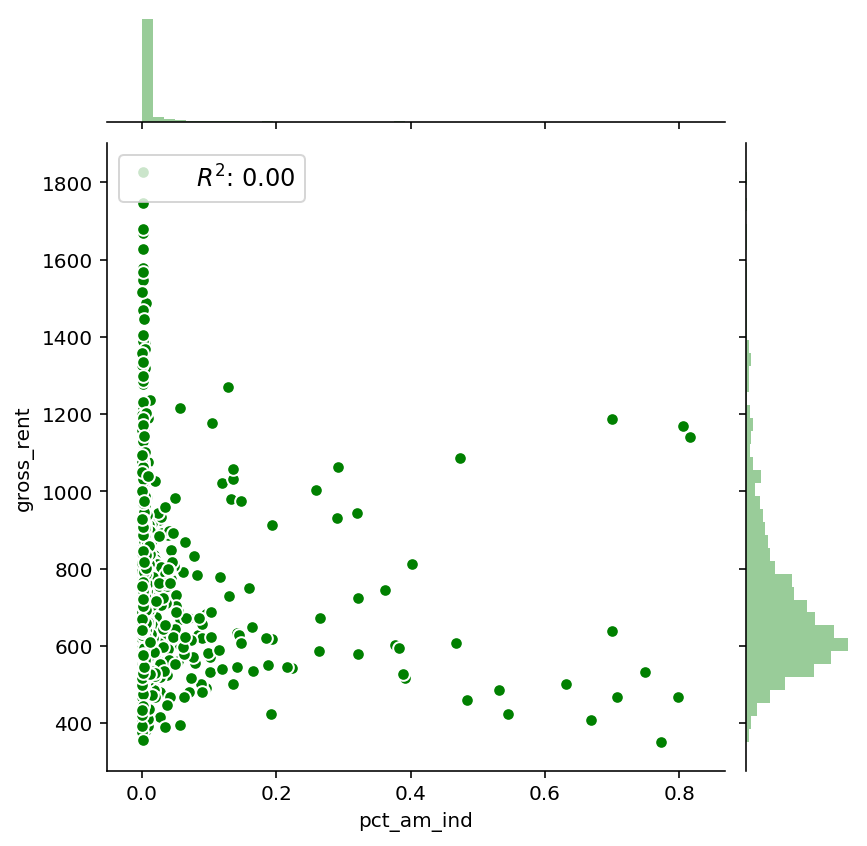

<Figure size 432x288 with 0 Axes>

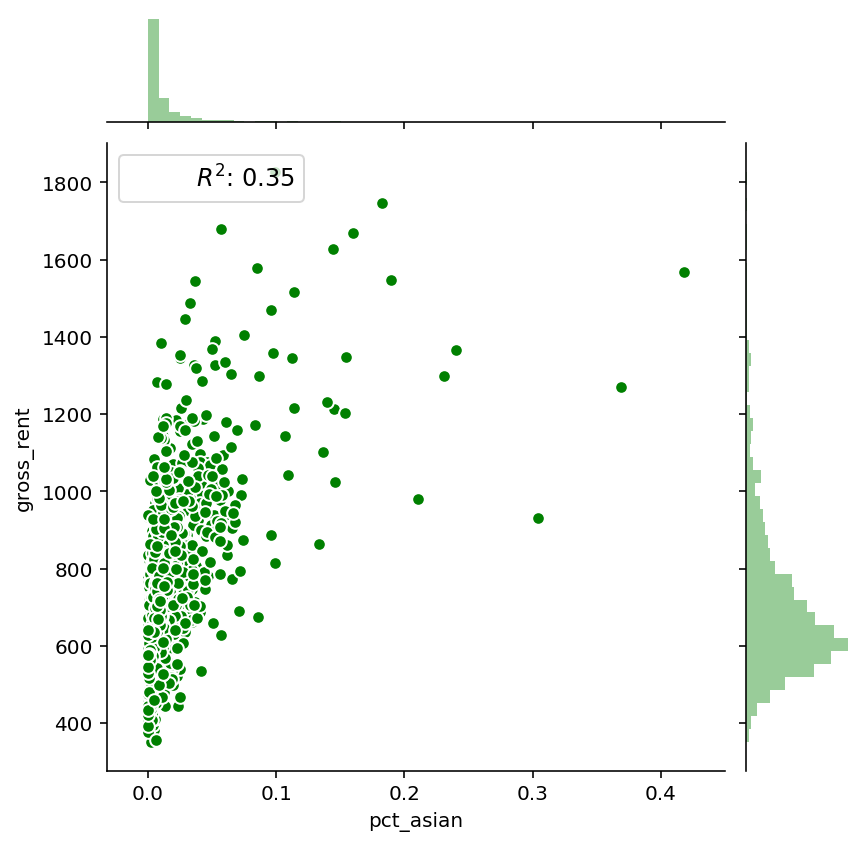

<Figure size 432x288 with 0 Axes>

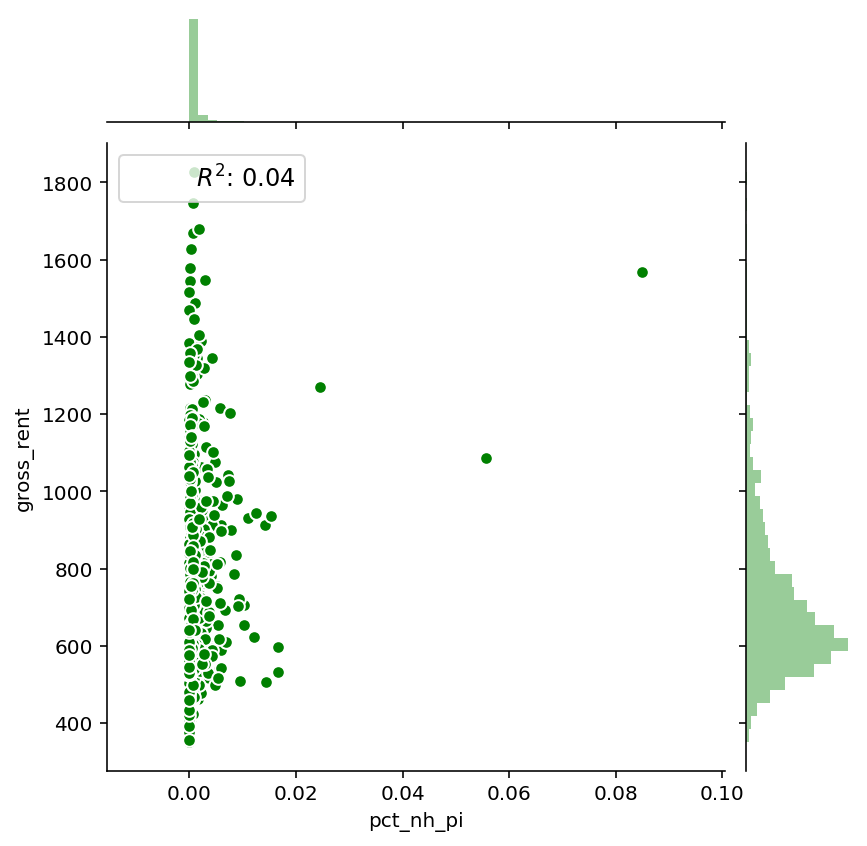

<Figure size 432x288 with 0 Axes>

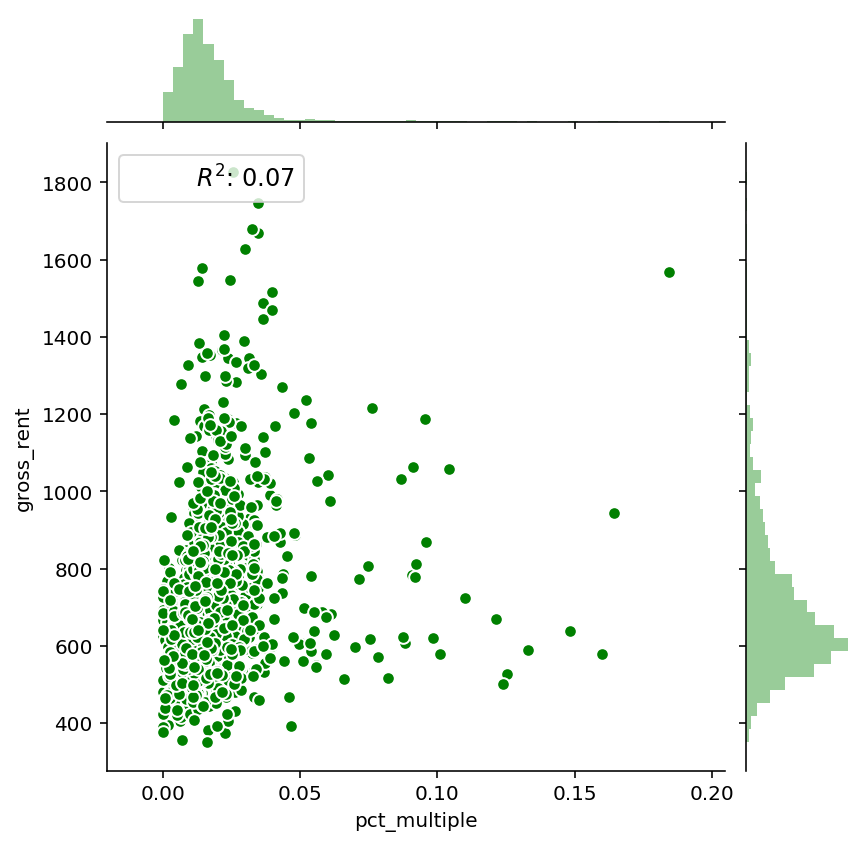

<Figure size 432x288 with 0 Axes>

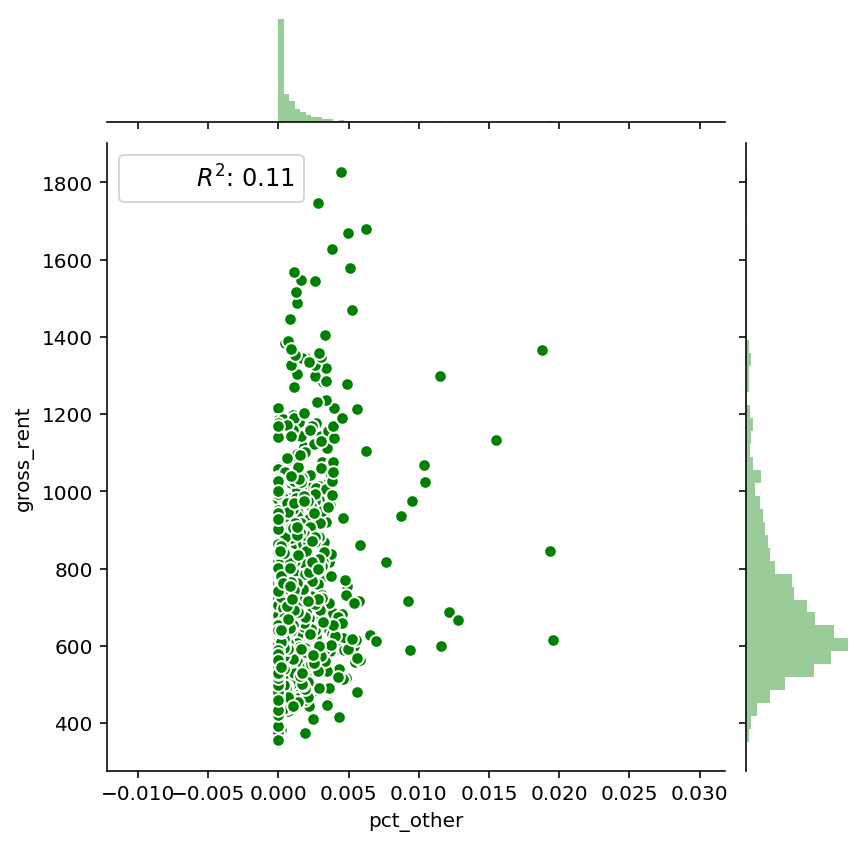

<Figure size 432x288 with 0 Axes>

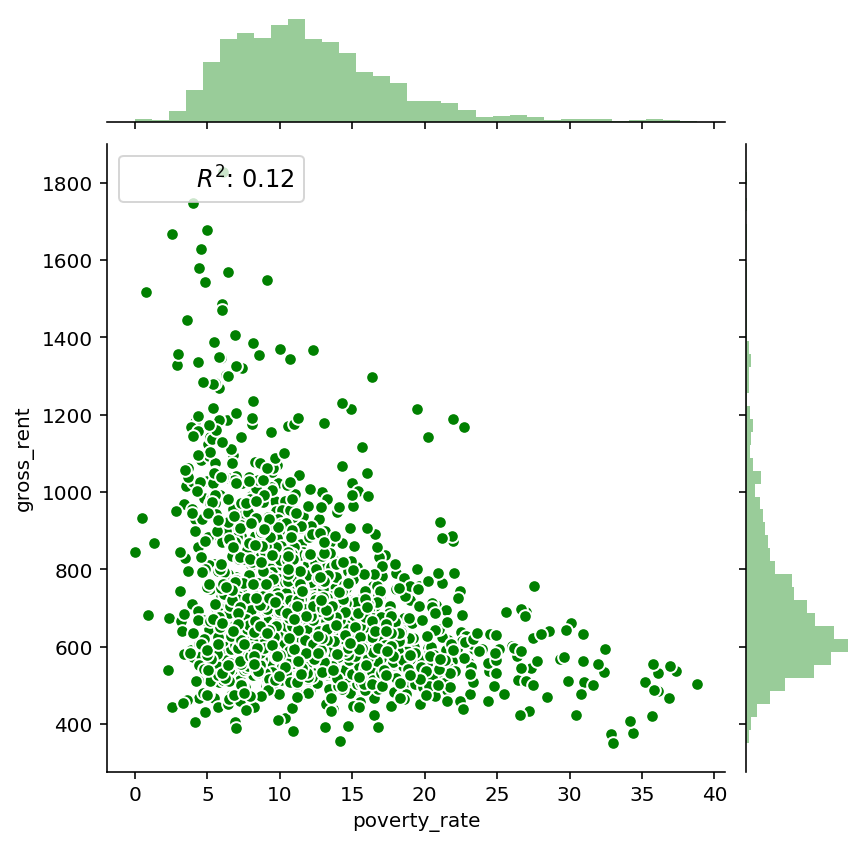

<Figure size 432x288 with 0 Axes>

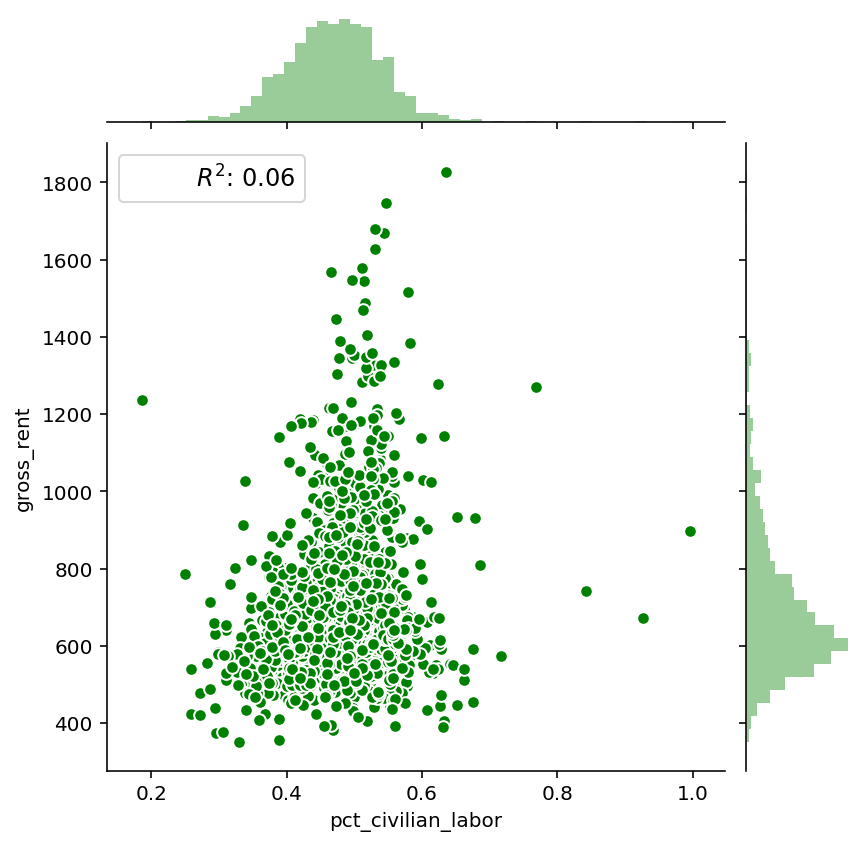

<Figure size 432x288 with 0 Axes>

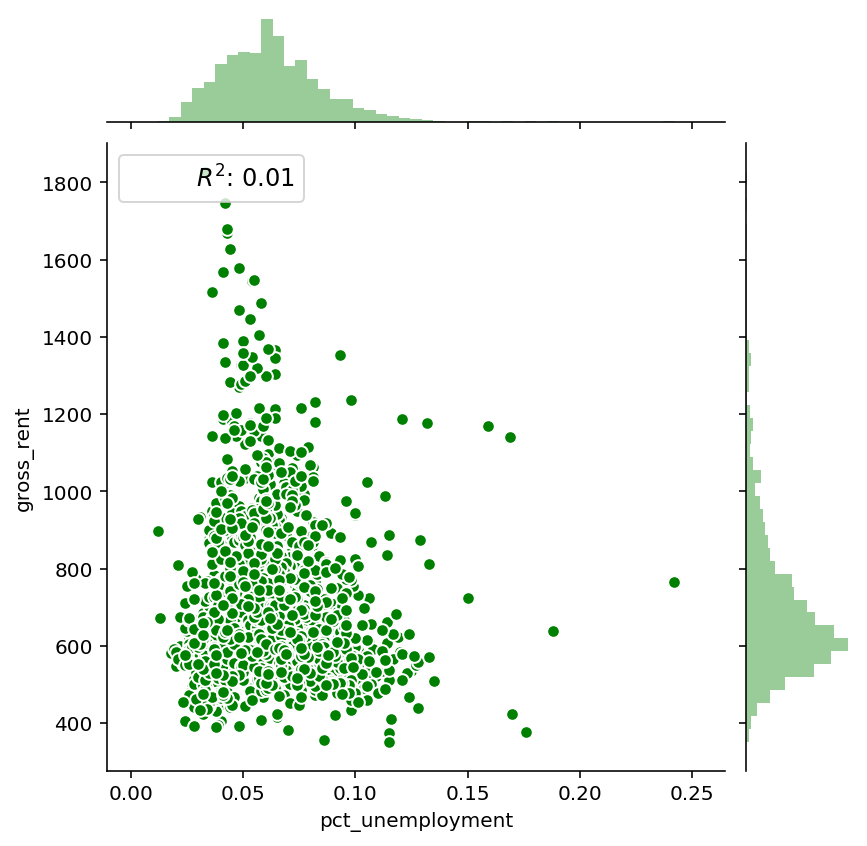

<Figure size 432x288 with 0 Axes>

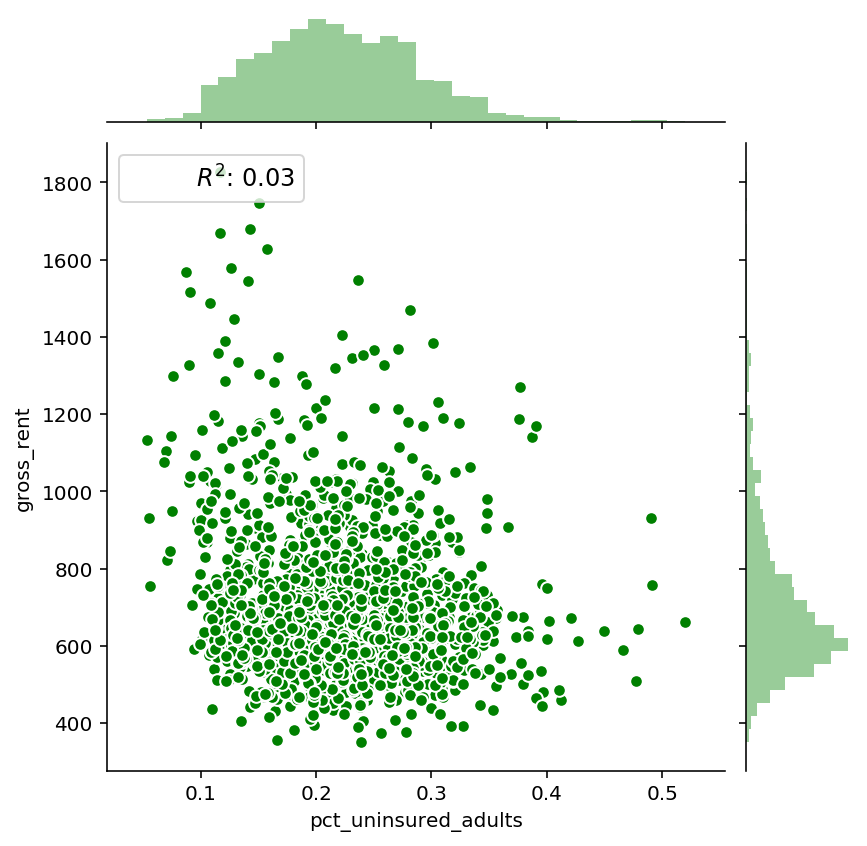

<Figure size 432x288 with 0 Axes>

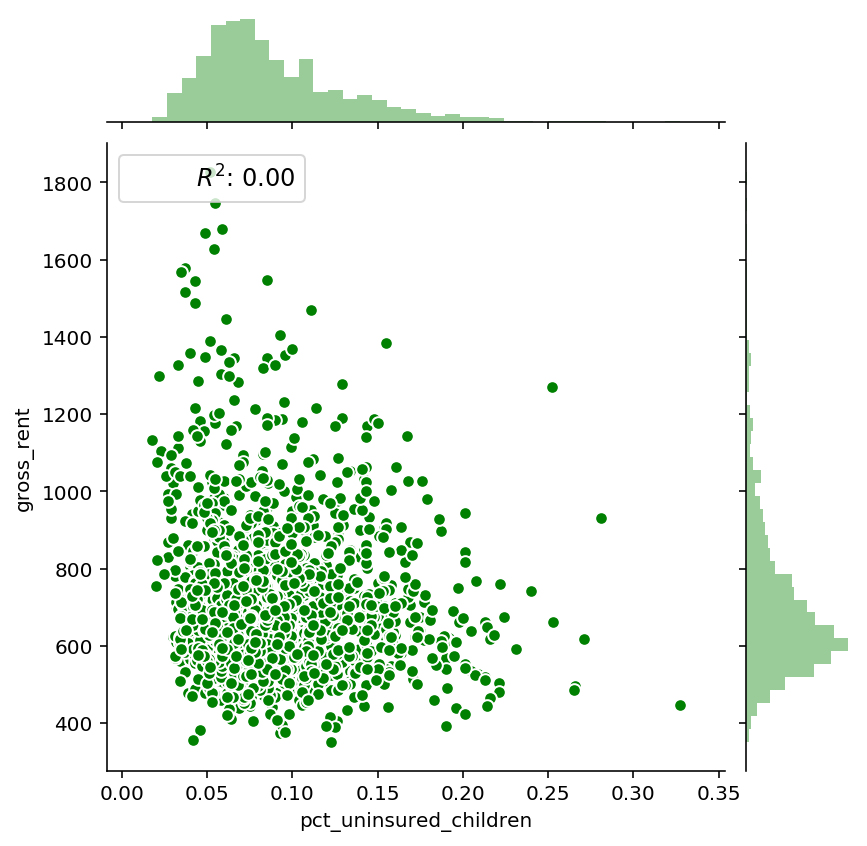

<Figure size 432x288 with 0 Axes>

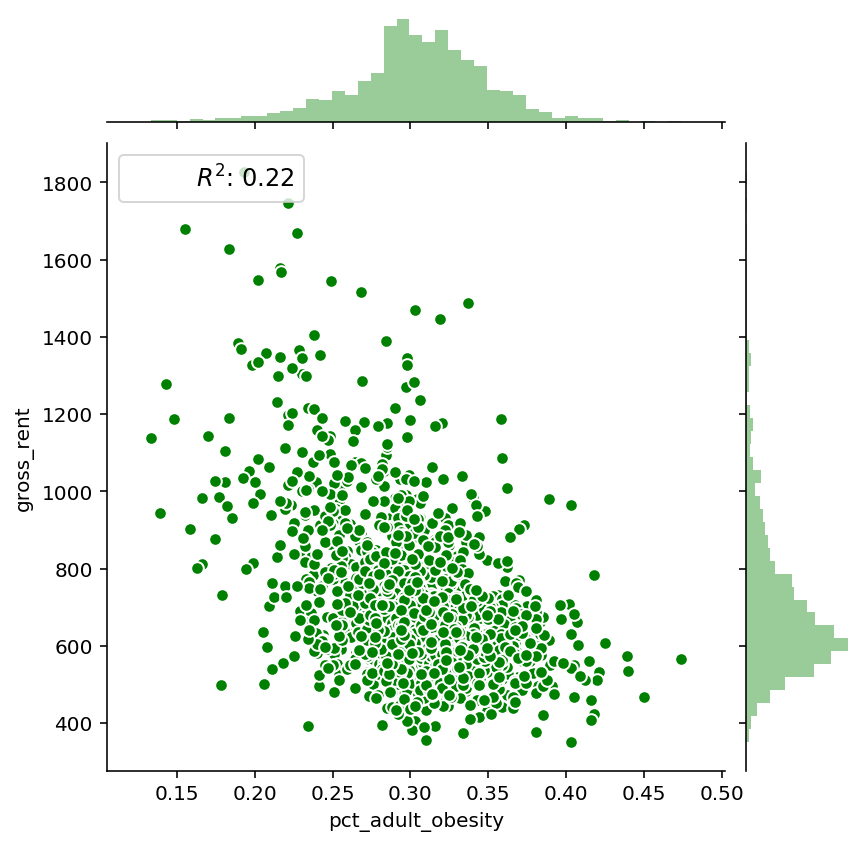

<Figure size 432x288 with 0 Axes>

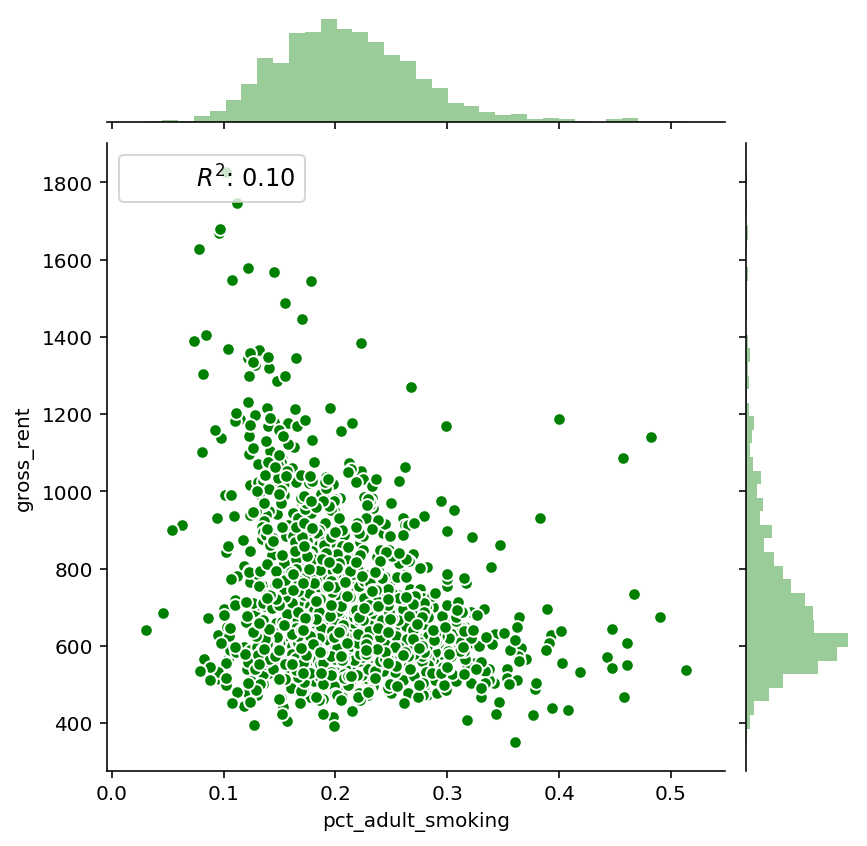

<Figure size 432x288 with 0 Axes>

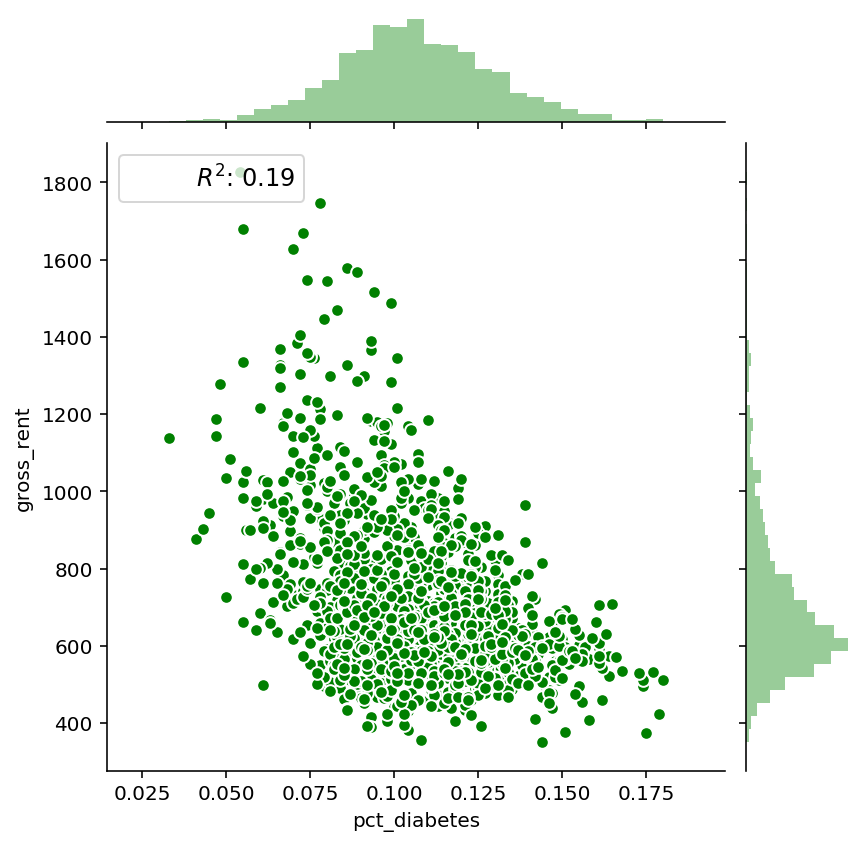

<Figure size 432x288 with 0 Axes>

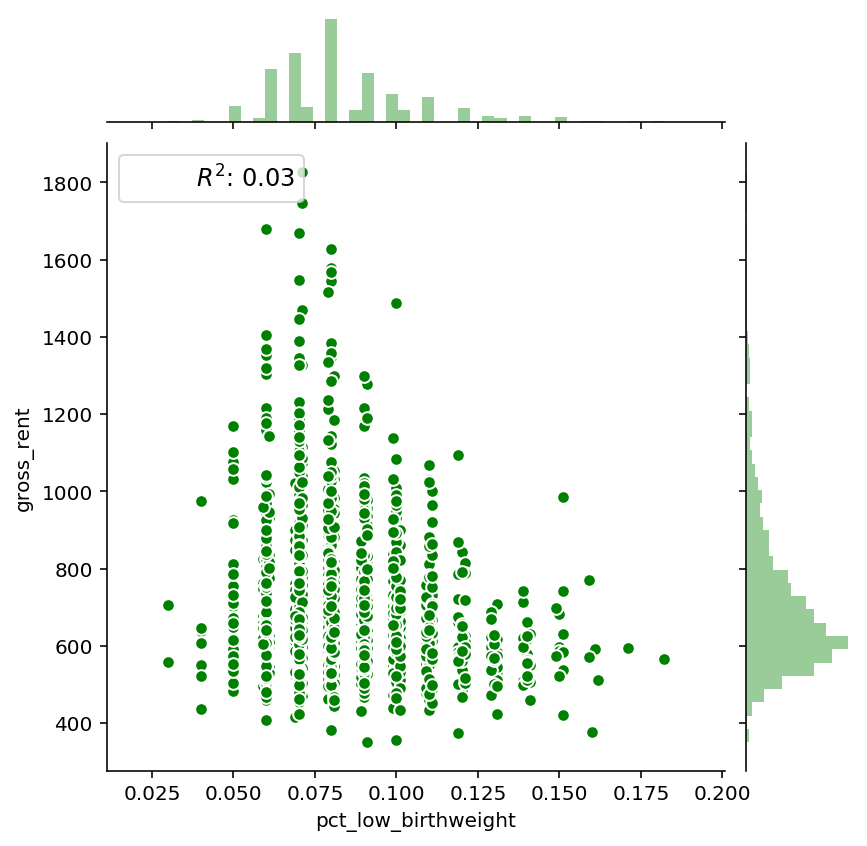

<Figure size 432x288 with 0 Axes>

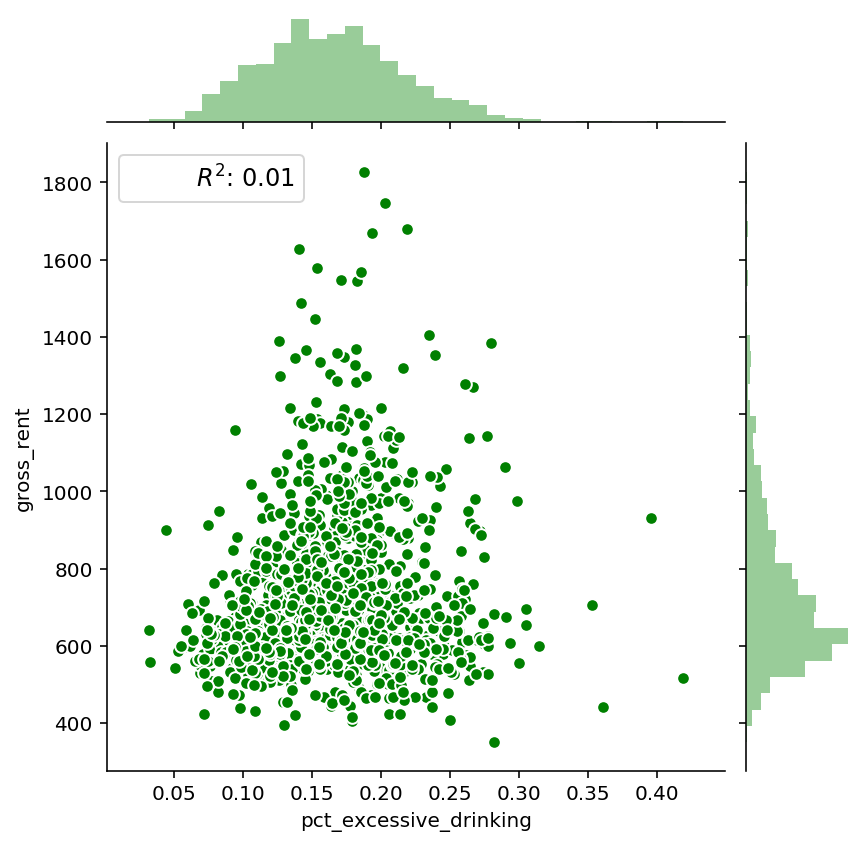

<Figure size 432x288 with 0 Axes>

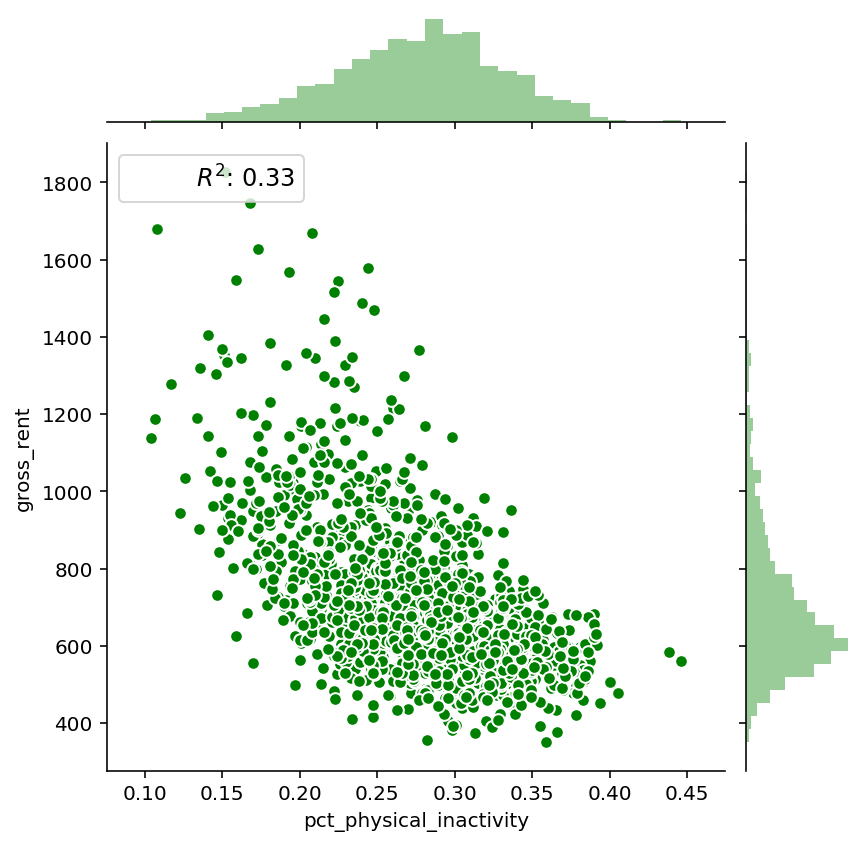

<Figure size 432x288 with 0 Axes>

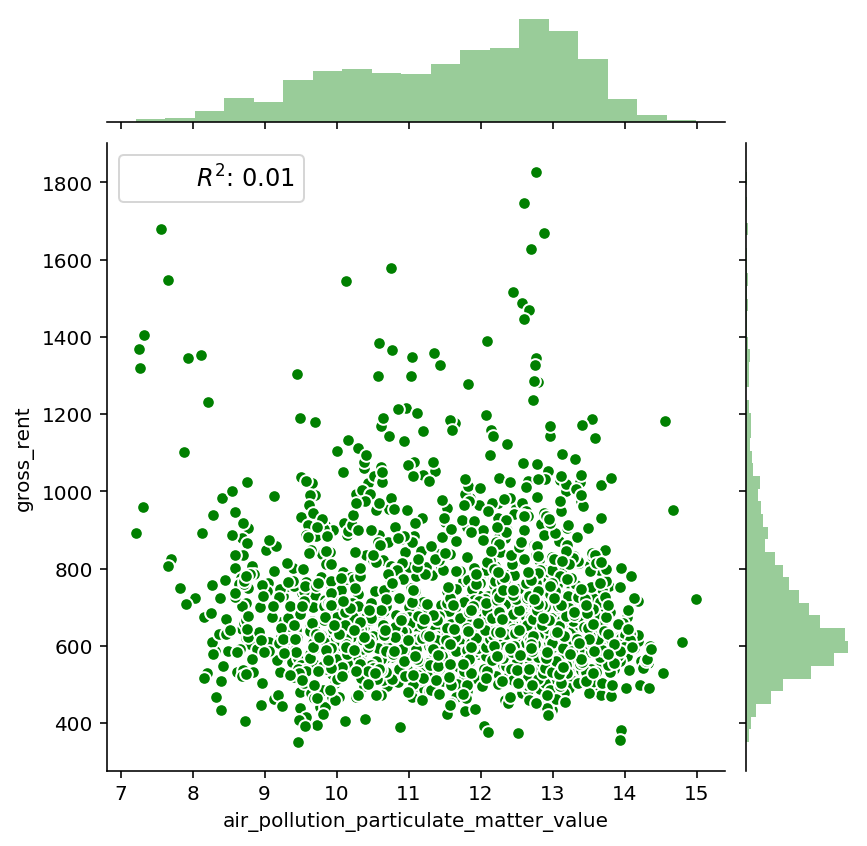

<Figure size 432x288 with 0 Axes>

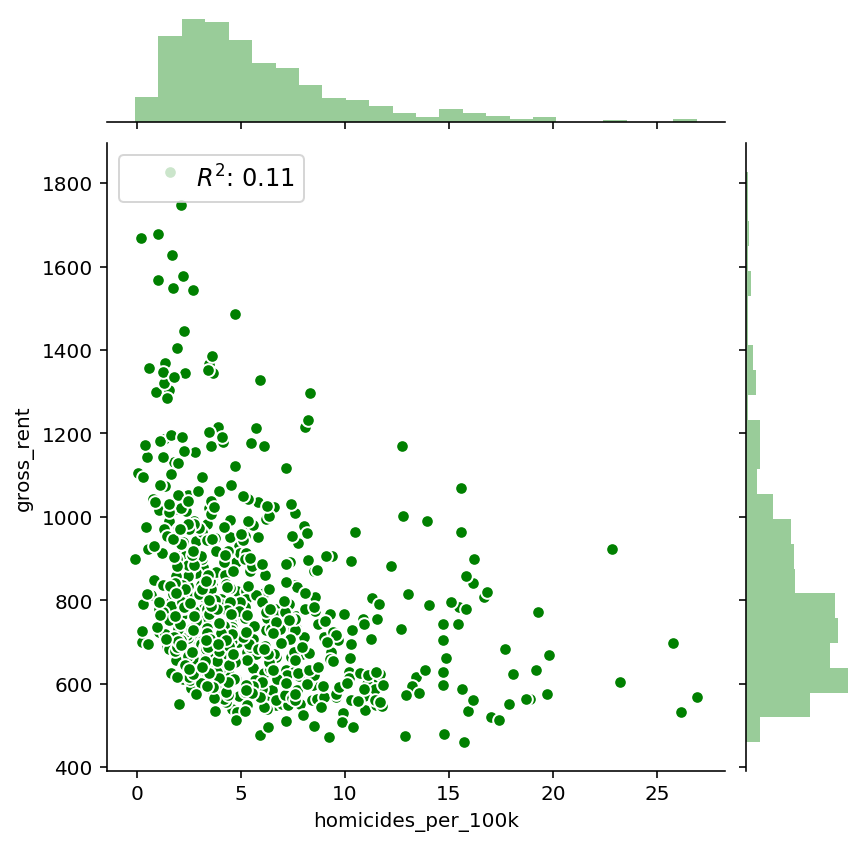

<Figure size 432x288 with 0 Axes>

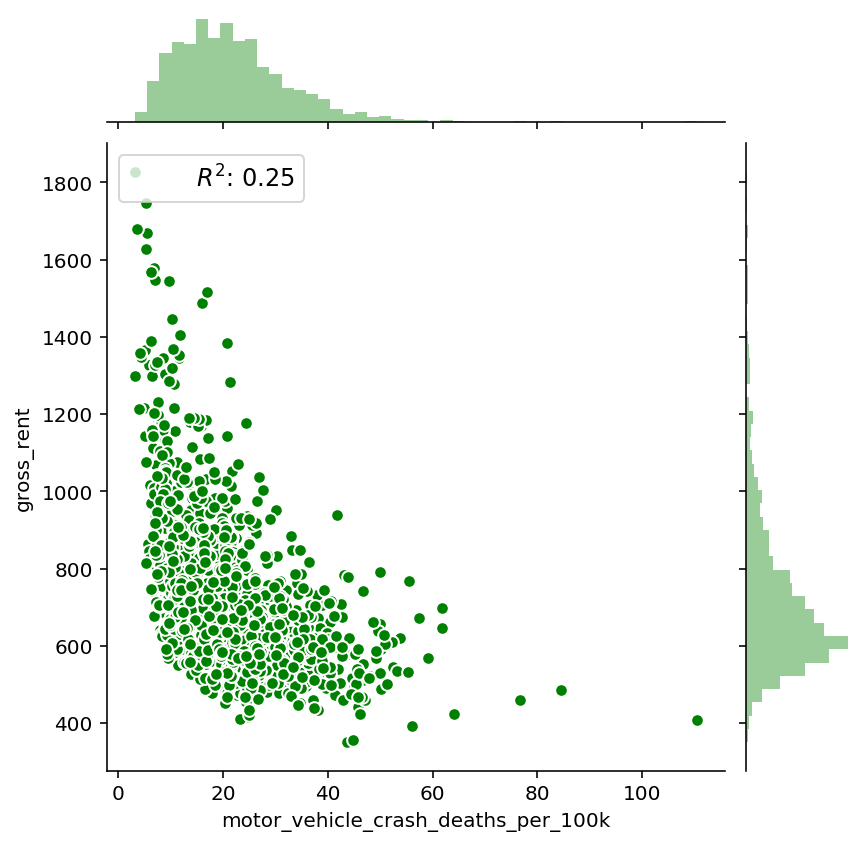

<Figure size 432x288 with 0 Axes>

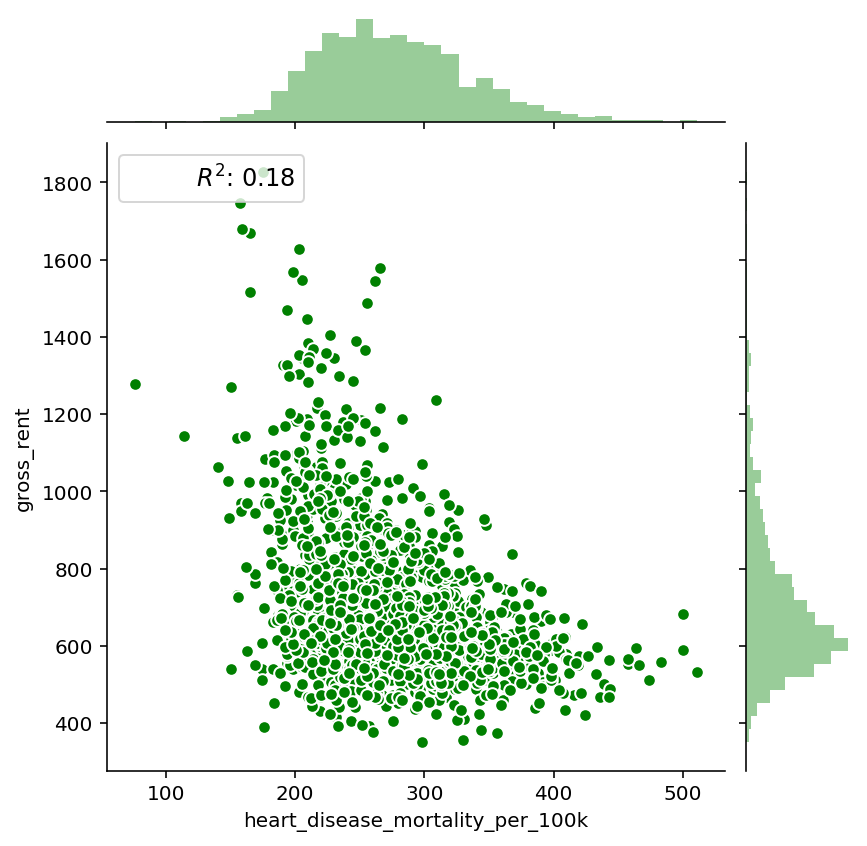

<Figure size 432x288 with 0 Axes>

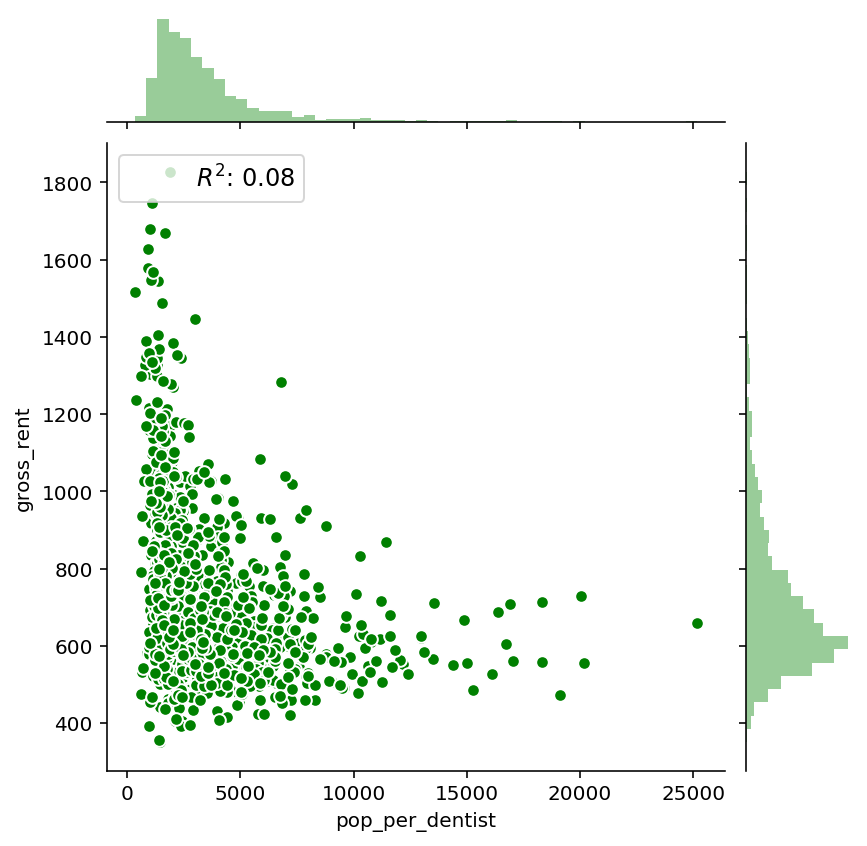

<Figure size 432x288 with 0 Axes>

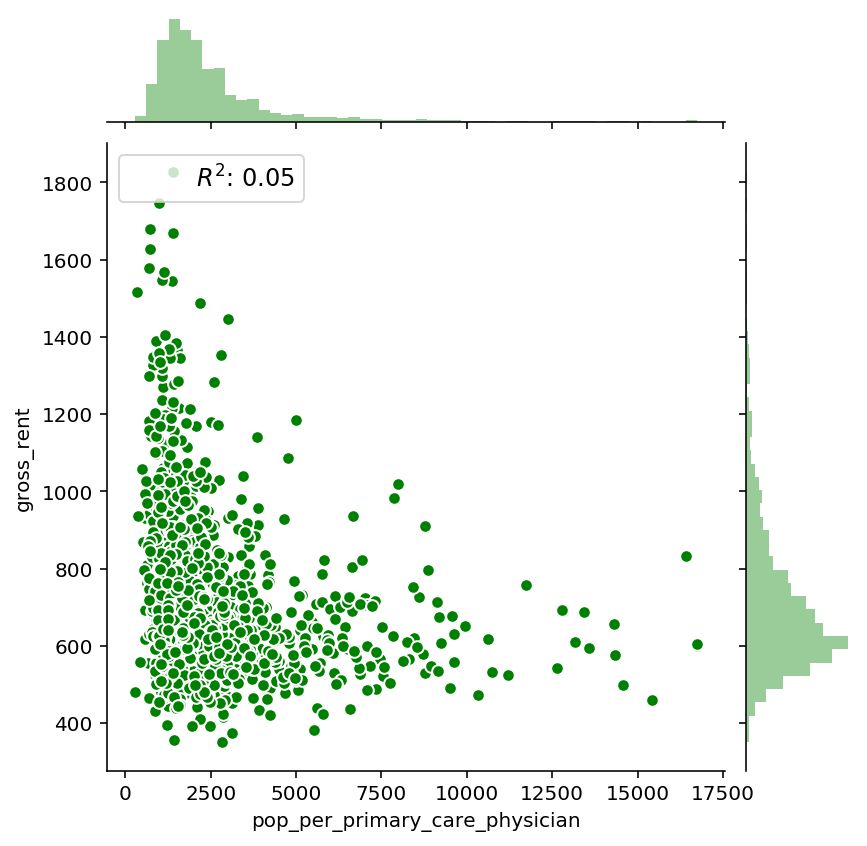

<Figure size 432x288 with 0 Axes>

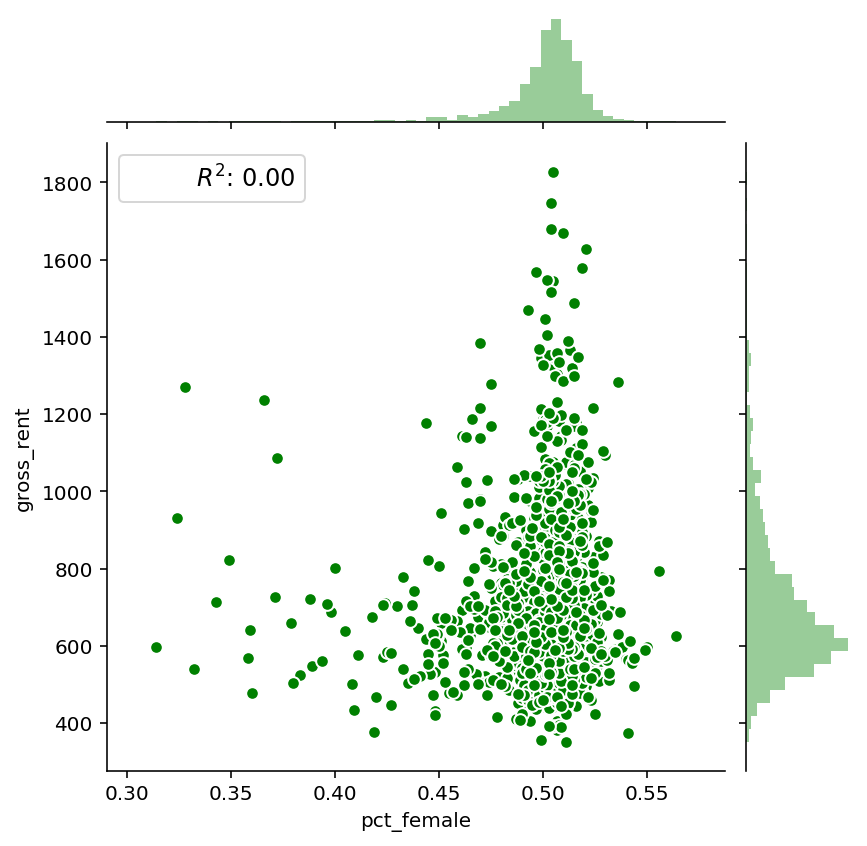

<Figure size 432x288 with 0 Axes>

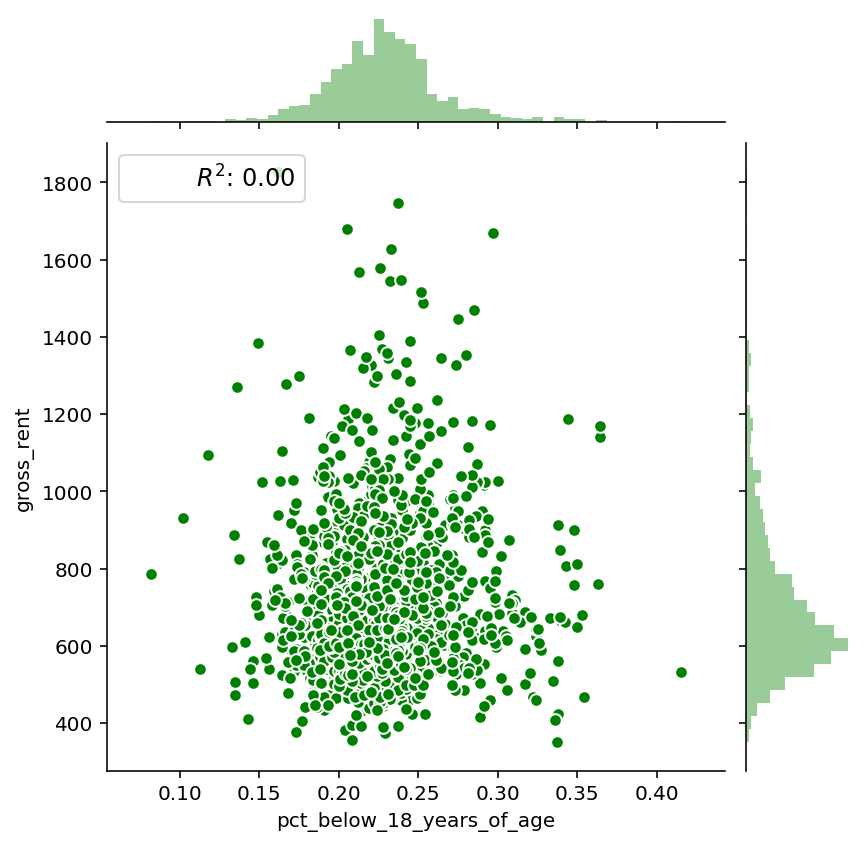

<Figure size 432x288 with 0 Axes>

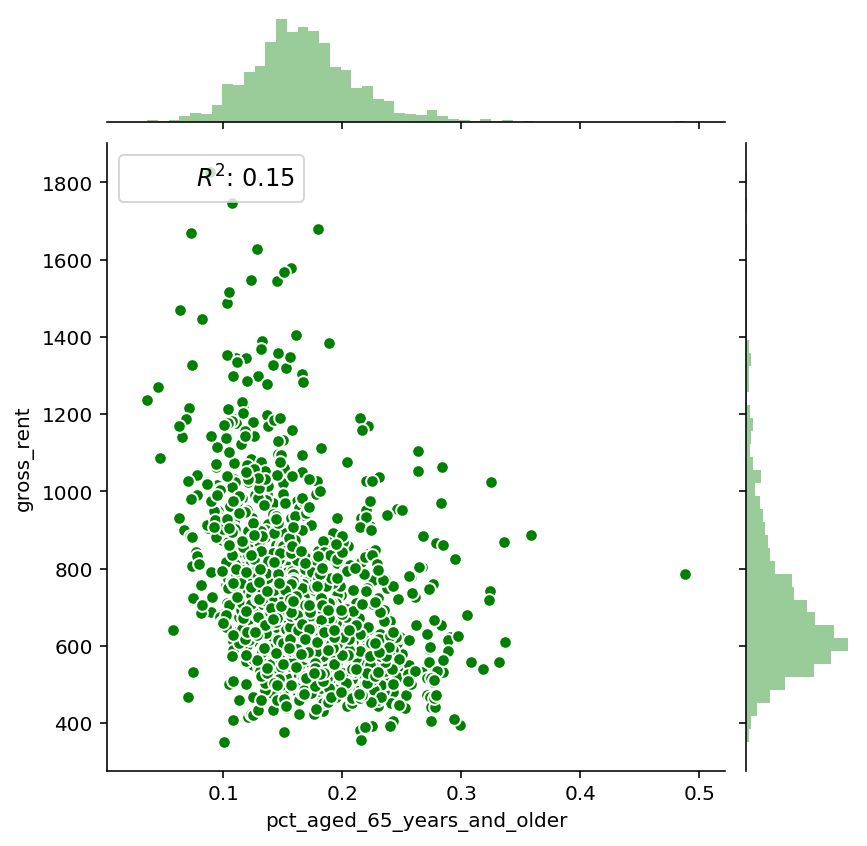

<Figure size 432x288 with 0 Axes>

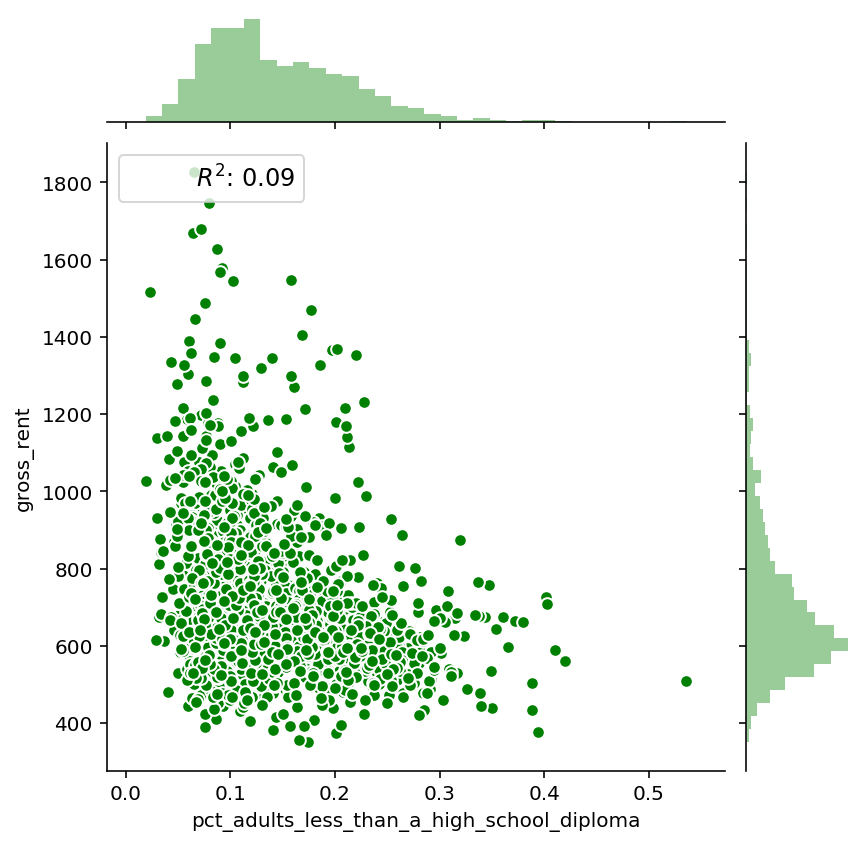

<Figure size 432x288 with 0 Axes>

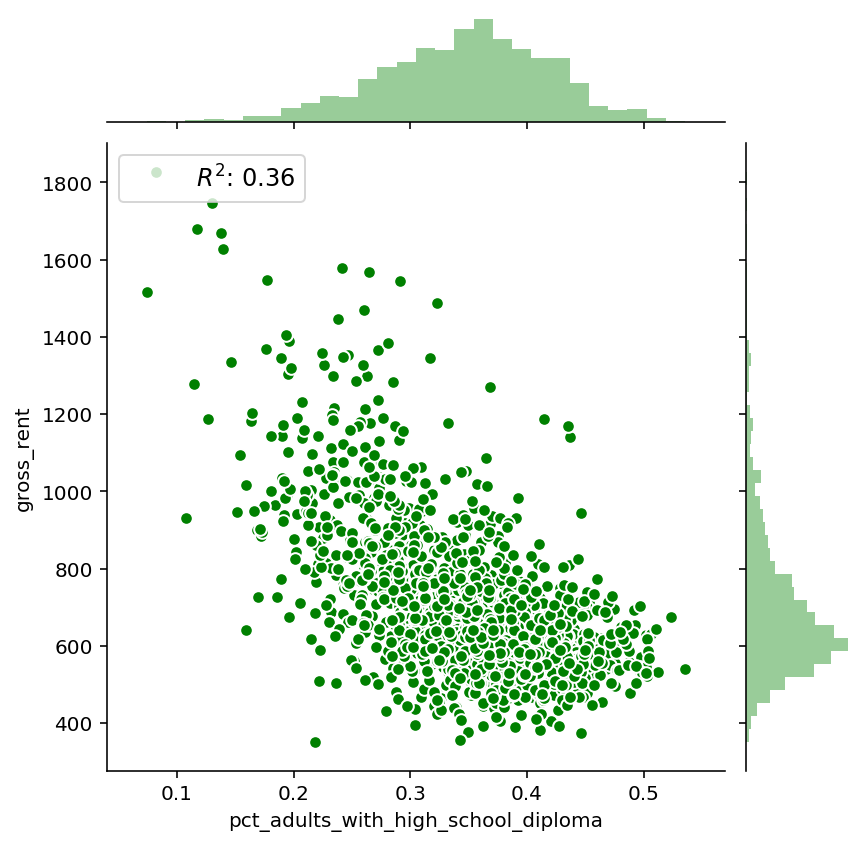

<Figure size 432x288 with 0 Axes>

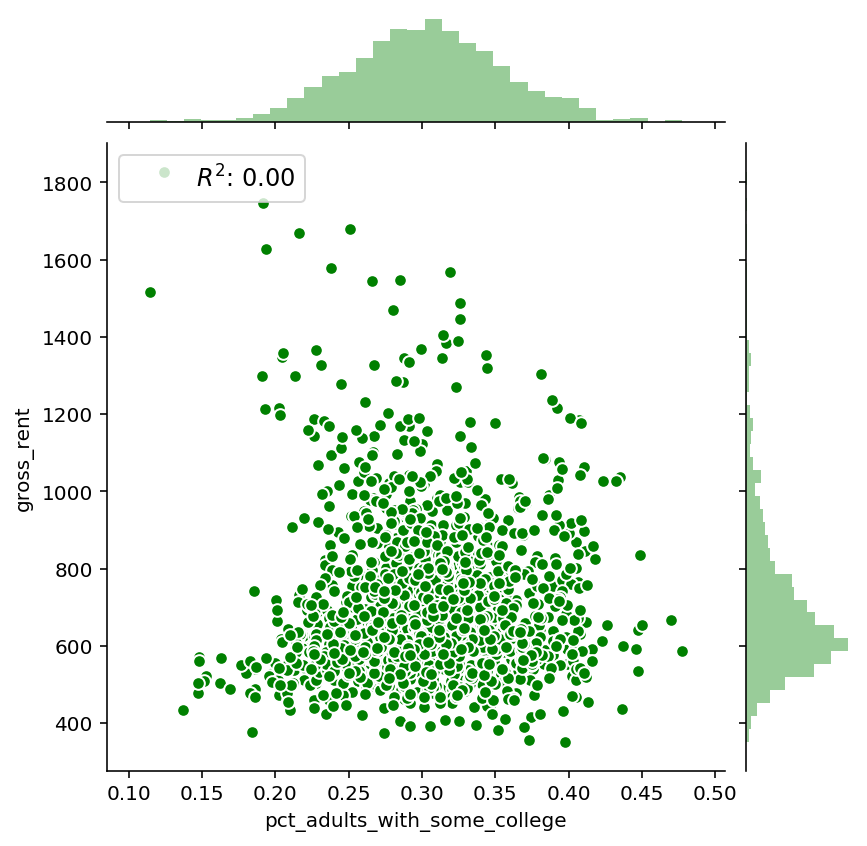

<Figure size 432x288 with 0 Axes>

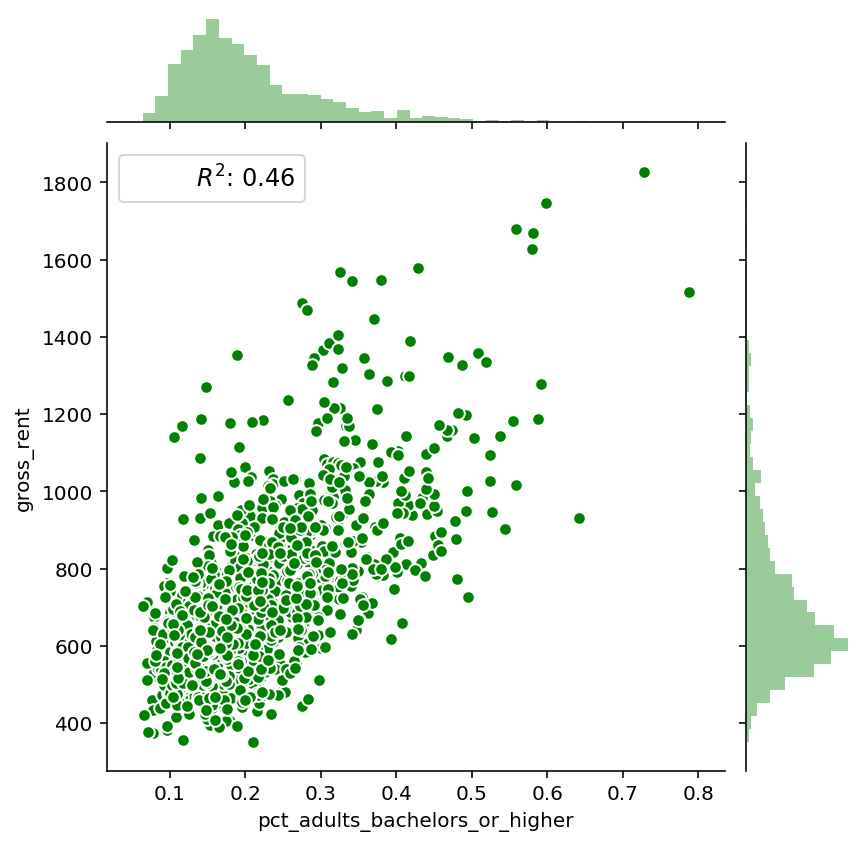

<Figure size 432x288 with 0 Axes>

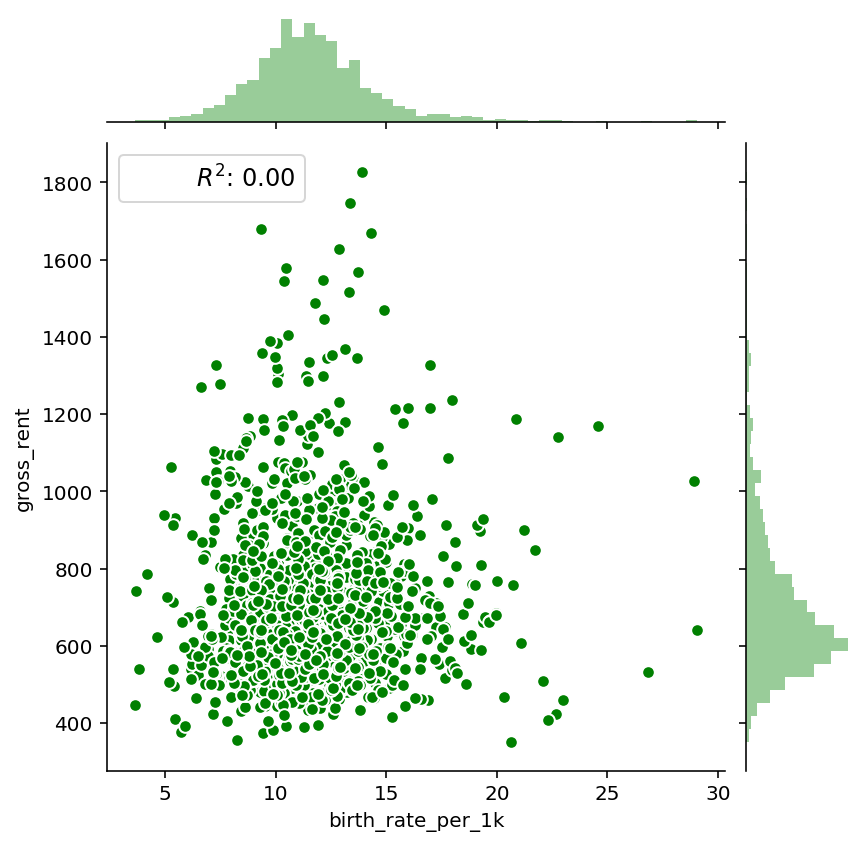

<Figure size 432x288 with 0 Axes>

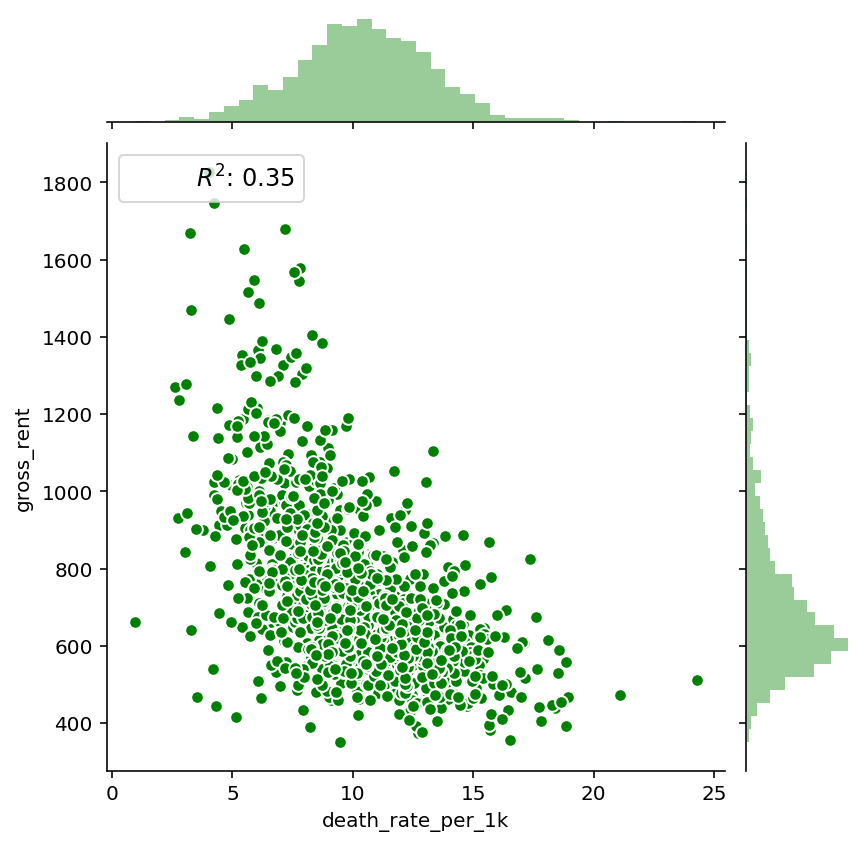

<Figure size 432x288 with 0 Axes>

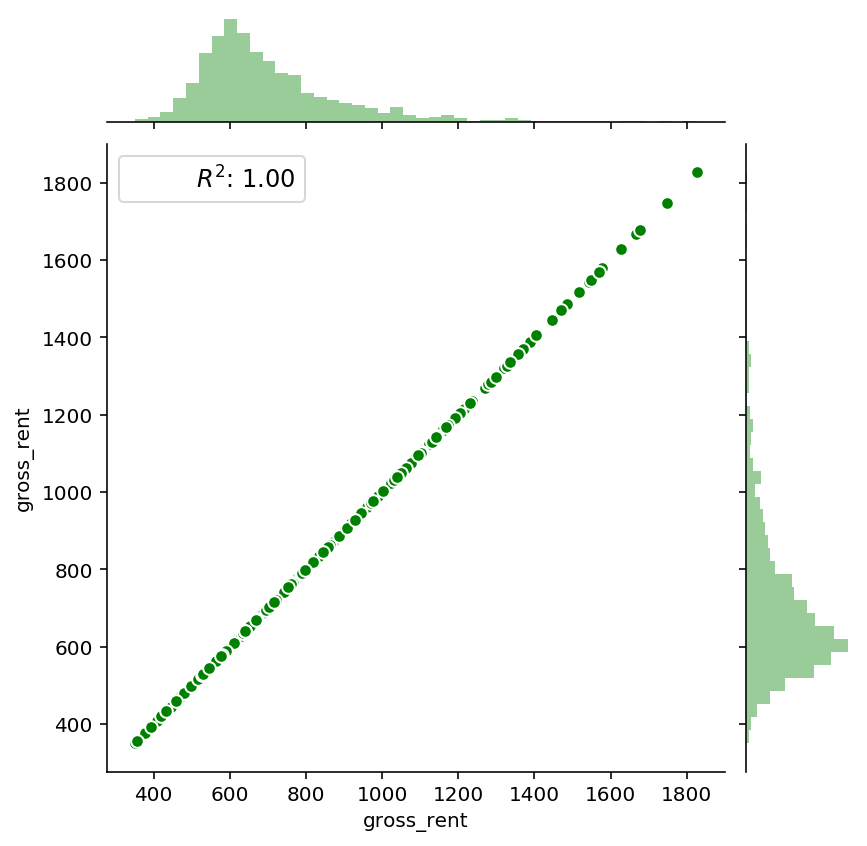

In [13]:
save_num_var=(True,False)
numvar_fig_path=Path.cwd()/"num_var_figs"
try:
    numvar_fig_path.mkdir()
except:
    FileExistsError


#with PdfPages(numvar_fig_path/'Dat102x_dec19_num_var.pdf') as pdf_pages:
for var in num_var.columns.values:
    fig=plt.figure(var)
    g = sns.JointGrid(x=var, y='gross_rent', data=num_var)
    g.plot_joint(plt.scatter,color="g", s=40, edgecolor="white")
    g.plot_marginals(sns.distplot, kde=False, color="g")
    rsquare = lambda a, b: stats.pearsonr(a, b)[0] ** 2
    g.annotate(rsquare, template="{stat}: {val:.2f}",
                   stat="$R^2$", loc="upper left", fontsize=12)
    plt.show() if save_num_var[0]==True else print("skip")
    #pdf_pages.savefig(fig) if save_numvar[1]==True else print("skip")
    fig_svg_name=str('num_fig_')+var+'.svg'
    fig_png_name=str('num_fig_')+var+'.png'
    g.savefig(numvar_fig_path/fig_svg_name, format="svg",transparent=True,dpi=300) if save_num_var[1]==True else None
    g.savefig(numvar_fig_path/fig_png_name, format="png",transparent=True,dpi=300) if save_num_var[1]==True else None
    plt.close()



In [14]:
#Relabeling cat values
#for var in cat_var.columns.values:
#    print(cat_var[var].unique())
    
rucc={'Nonmetro - Completely rural or less than 2,500 urban population, not adjacent to a metro area':'Nonmetro_urbpop<2.5^3_non_met_adj',
      'Nonmetro - Urban population of 2,500 to 19,999, not adjacent to a metro area':'Nonmetro_urbpop<2.0^4_non_met_adj',
      'Metro - Counties in metro areas of fewer than 250,000 population':'Metro_urbpop<2.5^5',
      'Metro - Counties in metro areas of 1 million population or more':'Metro_urbpop=>1.0^6',
      'Nonmetro - Urban population of 2,500 to 19,999, adjacent to a metro area':'Nonmetro_urbpop<2.0^4_met_adj',
      'Nonmetro - Urban population of 20,000 or more, adjacent to a metro area':'Nonmetro_urbpop=>2.0^4_met_adj',
      'Metro - Counties in metro areas of 250,000 to 1 million population':'Metro_urbpop<1.0^6',
      'Nonmetro - Completely rural or less than 2,500 urban population, adjacent to a metro area':'Nonmetro_urbpop<2.5^3_met_adj',
      'Nonmetro - Urban population of 20,000 or more, not adjacent to a metro area':'Nonmetro_urbpop=>2.0^4_non_met_adj'}

urban_influence={
    'Noncore adjacent to micro area and does not contain a town of at least 2,500 residents':'A',
    'Micropolitan not adjacent to a metro area':'B',
    'Noncore not adjacent to a metro/micro area and contains a town of 2,500  or more residents':'C',
    'Small-in a metro area with fewer than 1 million residents':'D',
    'Large-in a metro area with at least 1 million residents or more':'E',
    'Noncore adjacent to a small metro with town of at least 2,500 residents':'F',
    'Noncore not adjacent to a metro/micro area and does not contain a town of at least 2,500 residents':'G',
    'Micropolitan adjacent to a small metro area':'H',
    'Micropolitan adjacent to a large metro area':'I',
    'Noncore adjacent to micro area and contains a town of 2,500-19,999 residents':'J',
    'Noncore adjacent to a small metro and does not contain a town of at least 2,500 residents':'K',
    'Noncore adjacent to a large metro area':'L'
                }
di={'rucc':rucc,'urban_influence': urban_influence}
#print(type(di), type(di[0]))
#print(di)
renamed_cat=train
for var in cat_var.columns.values:
    print(var)
    if var in di:
        renamed_cat.replace({var: di[var]}, inplace=True)
        renamed_cat[var].map(di[var])
        print(renamed_cat[var].unique())
    else:
        continue
cat_var.head()

county_code
state
rucc
['Nonmetro_urbpop<2.5^3_non_met_adj' 'Nonmetro_urbpop<2.0^4_non_met_adj'
 'Metro_urbpop<2.5^5' 'Metro_urbpop=>1.0^6'
 'Nonmetro_urbpop<2.0^4_met_adj' 'Nonmetro_urbpop=>2.0^4_met_adj'
 'Metro_urbpop<1.0^6' 'Nonmetro_urbpop<2.5^3_met_adj'
 'Nonmetro_urbpop=>2.0^4_non_met_adj']
urban_influence
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L']
economic_typology


county_code    state  \
row_id                        
0          8e686a7  fb8cab1   
1          d1b5fc5  842bd12   
2          19a463b  2b7da97   
3          1711ab7  5029ed4   
4          1eb4681  b795815   

                                                     rucc  \
row_id                                                      
0       Nonmetro - Completely rural or less than 2,500...   
1       Nonmetro - Completely rural or less than 2,500...   
2       Nonmetro - Urban population of 2,500 to 19,999...   
3       Nonmetro - Urban population of 2,500 to 19,999...   
4       Nonmetro - Completely rural or less than 2,500...   

                                          urban_influence  \
row_id                                                      
0       Noncore adjacent to micro area and does not co...   
1               Micropolitan not adjacent to a metro area   
2       Noncore not adjacent to a metro/micro area and...   
3       Noncore not adjacent to a metro/micro area and...   
4       Noncore adjacent to micro area and does not co...   

              economic_typology  
row_id                           
0       Manufacturing-dependent  
1                    Recreation  
2                    Recreation  
3                Nonspecialized  
4                Farm-dependent

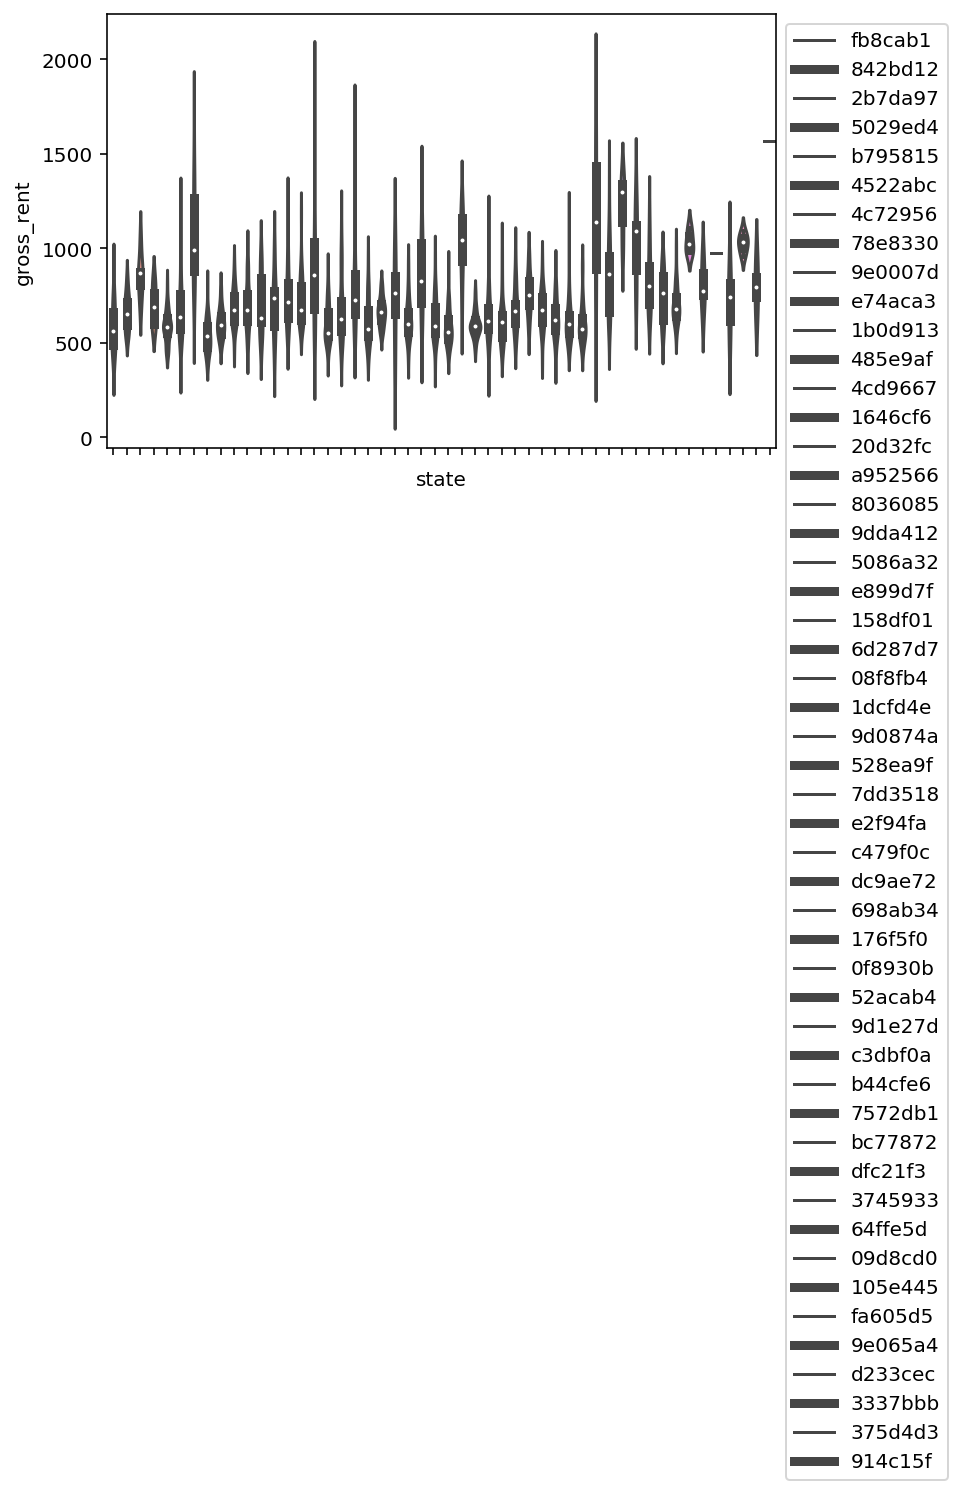

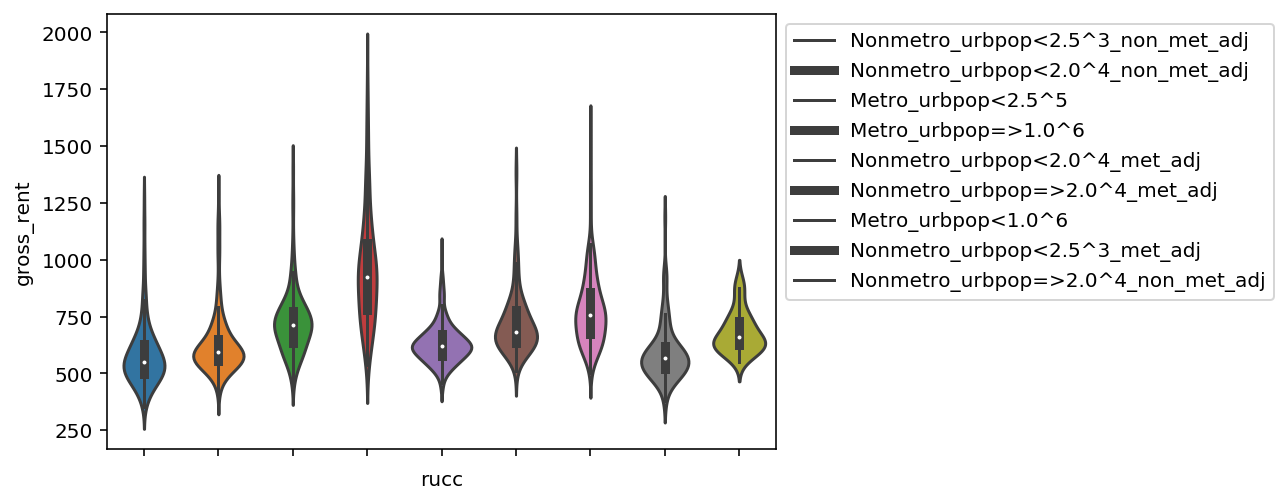

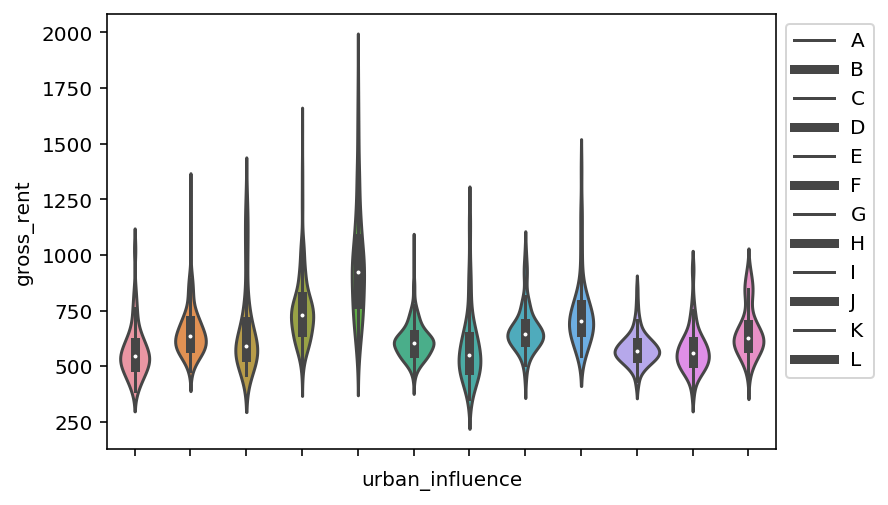

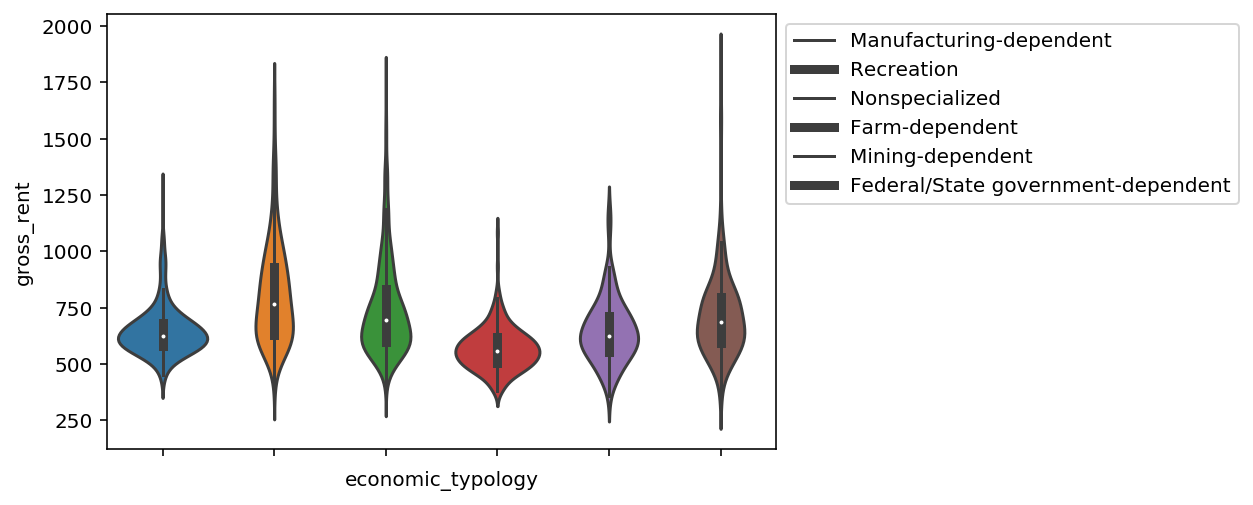

In [15]:
save_cat_var=(True,False)
catvar_fig_path=Path.cwd()/"cat_var_figs"
try:
    catvar_fig_path.mkdir()
except:
    FileExistsError

#with PdfPages('Dat102x_dec19_cat_var.pdf') as pdf_pages:
for var in cat_var.columns.values:
    if var!="county_code":
        fig=plt.figure(var)
        g=sns.violinplot(x=var, y='gross_rent', data=renamed_cat)
        g.set(xticklabels=[])
        g.set_label
        g.legend(labels=renamed_cat[var].unique(), loc='upper left', bbox_to_anchor=(1, 1))
        plt.show() if save_cat_var[0]==True else print("skip")
        fig_svg_name=str('cat_fig_')+var+'.svg'
        fig_png_name=str('cat_fig_')+var+'.png'
        fig.savefig(catvar_fig_path/fig_svg_name, format="svg",transparent=True,dpi=300) if save_cat_var[1]==True else None
        fig.savefig(catvar_fig_path/fig_png_name, format="png",transparent=True,dpi=300) if save_cat_var[1]==True else None
        plt.close()

Strongly skewed:

population,renter_occupied_households,evictions,pct_am_ind,pct_asians,pct_nh_pi,pct_multiple,pct_other

mildly skewed:

pct_white,pct_af_am,pct_hispanic

promising predictors with middle to strong correlation:

poverty_rate,pct_adult_obesity,pct_adult_smoking,pct_diabetes,pct_physical_inactivity,
motor_vehicle_drash_deaths_per_100k,heart_disease_mortality_per_100k,'pct_aged_65_years_and_older','pct_adults_with_high_school_diploma','pct_adults_bachelors_or_higher','death_rate_per_1k'

predictors with weak correlation:



In [16]:
colname={}
for idx,col in enumerate(num_var.columns.values):
    colname[idx]=col
print(colname)
    

{0: 'population', 1: 'renter_occupied_households', 2: 'pct_renter_occupied', 3: 'evictions', 4: 'rent_burden', 5: 'pct_white', 6: 'pct_af_am', 7: 'pct_hispanic', 8: 'pct_am_ind', 9: 'pct_asian', 10: 'pct_nh_pi', 11: 'pct_multiple', 12: 'pct_other', 13: 'poverty_rate', 14: 'pct_civilian_labor', 15: 'pct_unemployment', 16: 'pct_uninsured_adults', 17: 'pct_uninsured_children', 18: 'pct_adult_obesity', 19: 'pct_adult_smoking', 20: 'pct_diabetes', 21: 'pct_low_birthweight', 22: 'pct_excessive_drinking', 23: 'pct_physical_inactivity', 24: 'air_pollution_particulate_matter_value', 25: 'homicides_per_100k', 26: 'motor_vehicle_crash_deaths_per_100k', 27: 'heart_disease_mortality_per_100k', 28: 'pop_per_dentist', 29: 'pop_per_primary_care_physician', 30: 'pct_female', 31: 'pct_below_18_years_of_age', 32: 'pct_aged_65_years_and_older', 33: 'pct_adults_less_than_a_high_school_diploma', 34: 'pct_adults_with_high_school_diploma', 35: 'pct_adults_with_some_college', 36: 'pct_adults_bachelors_or_highe

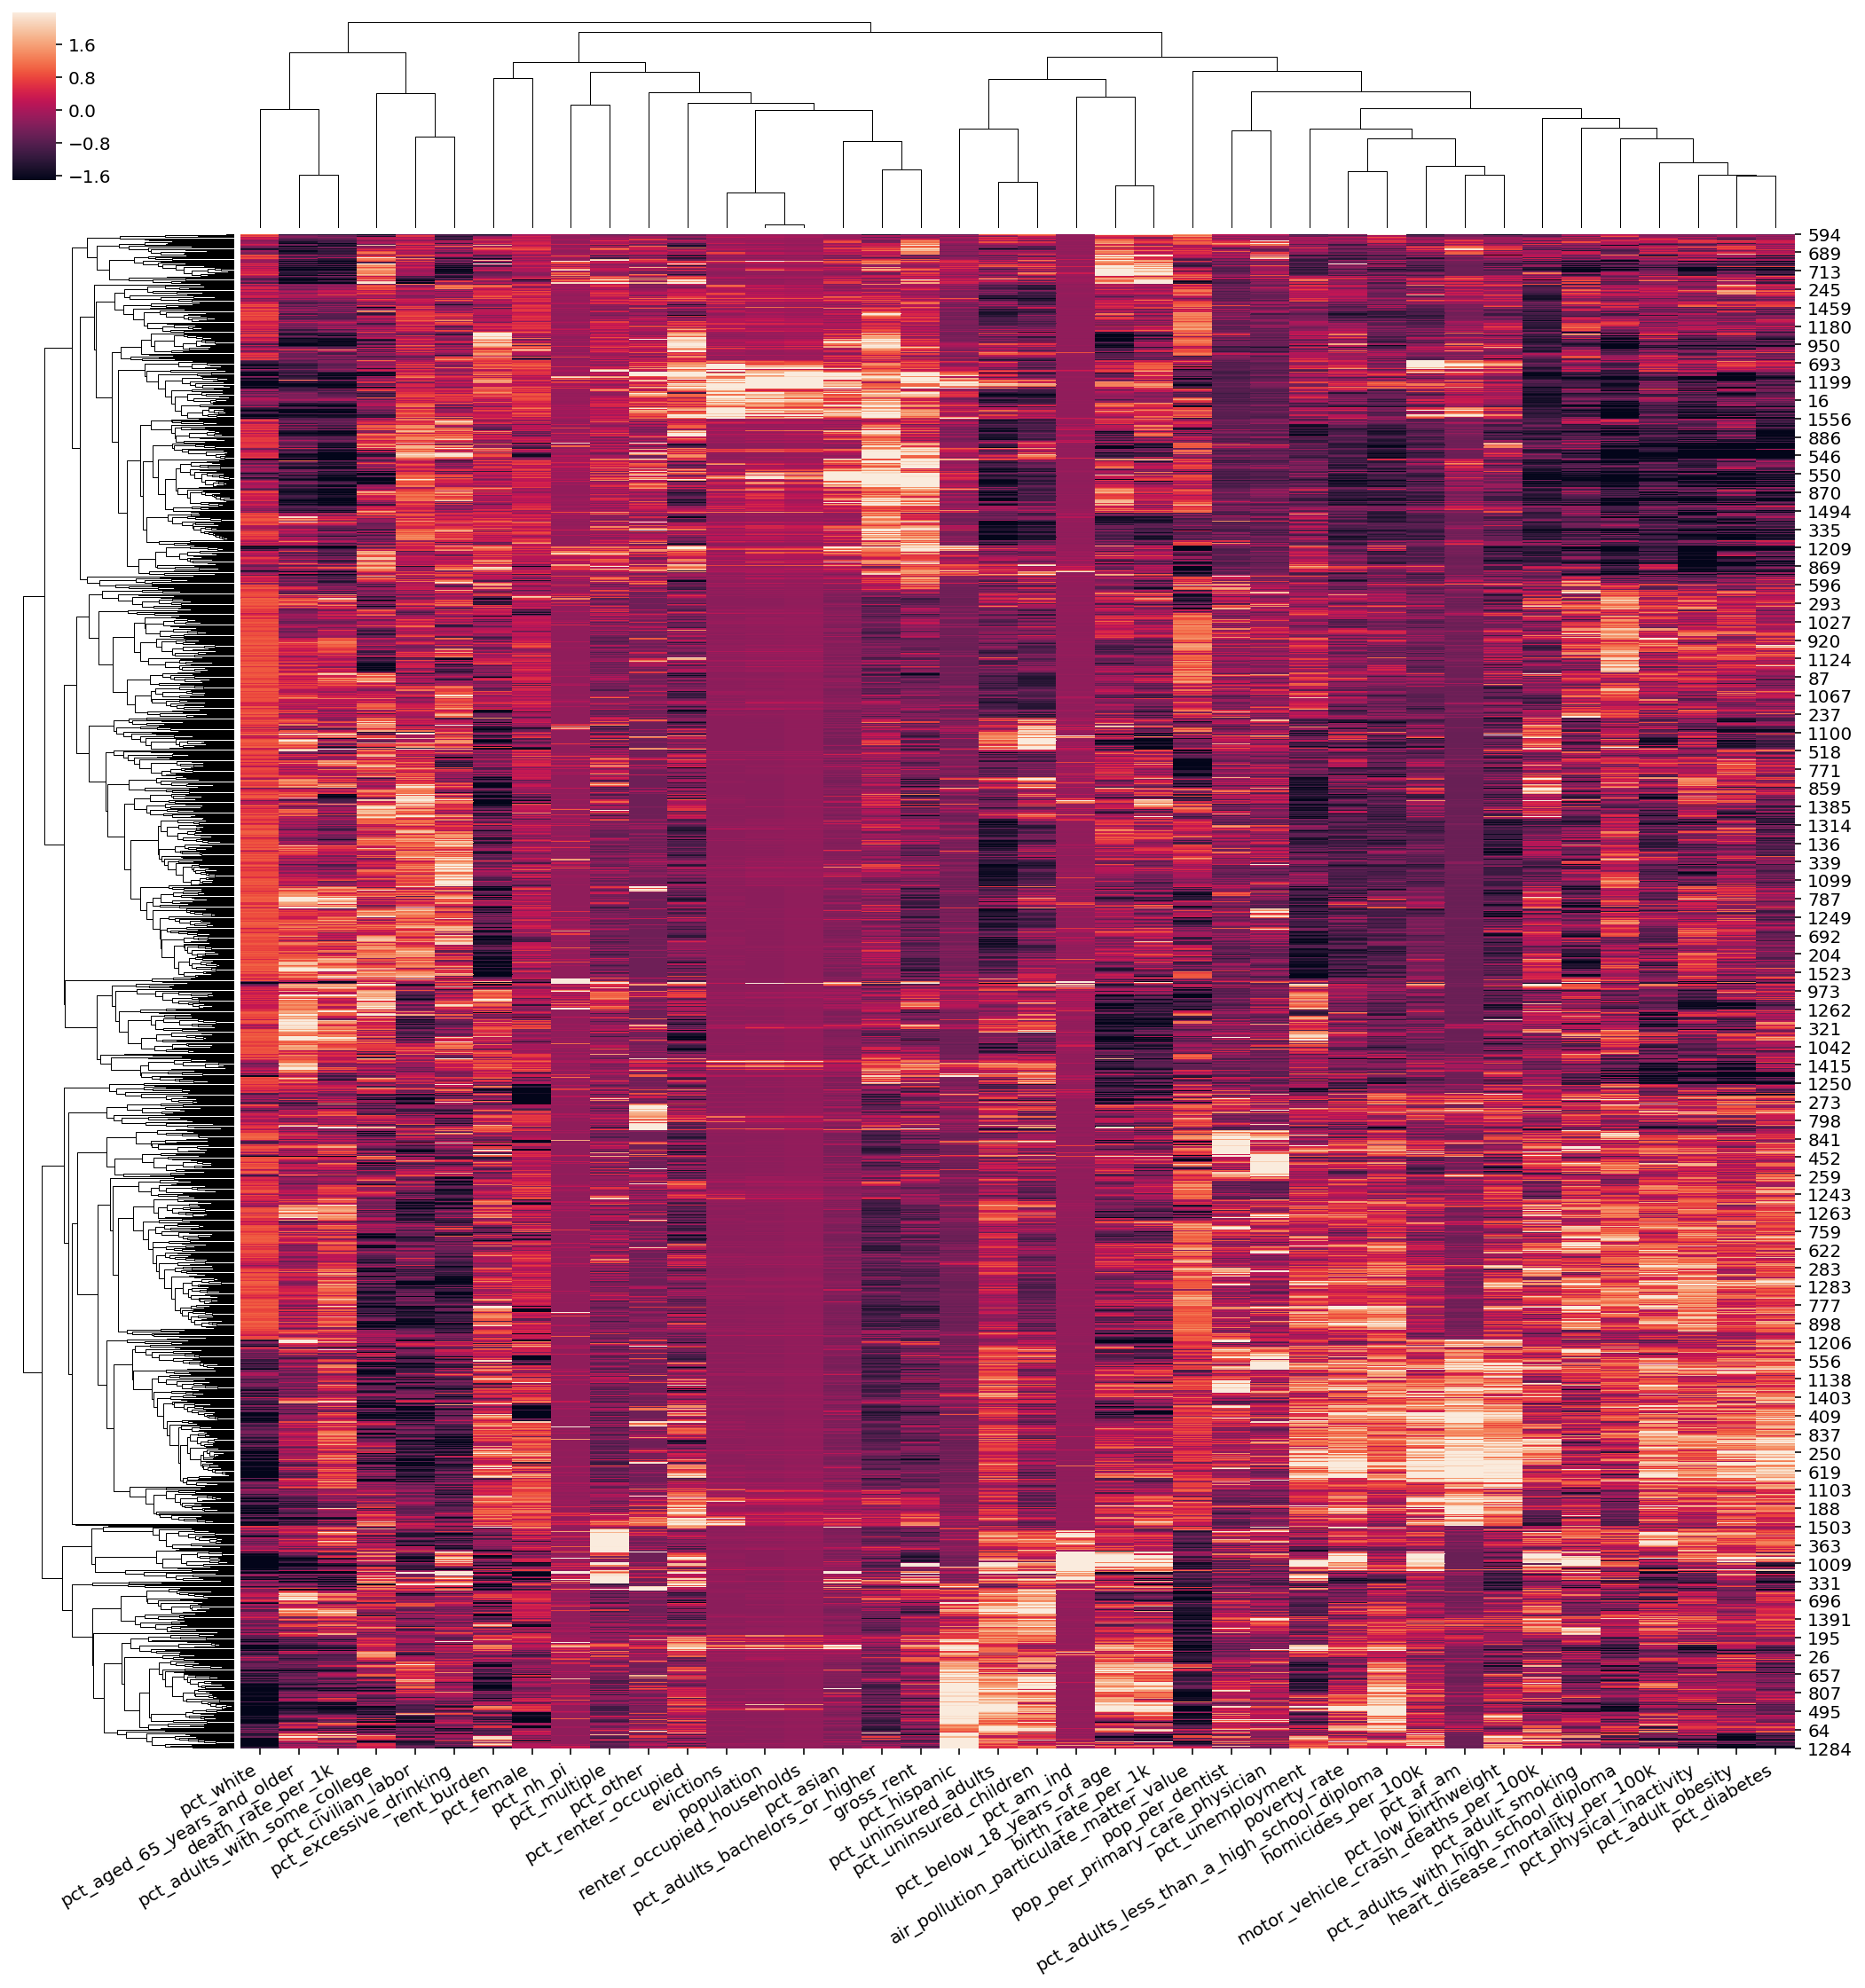

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

cluster_map_path=Path.cwd()/"cluster_map"
try:
    cluster_map_path.mkdir()
except:
    FileExistsError

save_cluster_map=False

clust_plot=IterativeImputer()
imputed_num_var=pd.DataFrame(clust_plot.fit_transform(num_var))
imputed_num_var.rename(columns=colname,inplace=True)
g = sns.clustermap(imputed_num_var, metric="correlation", robust=True, z_score=1, figsize=(18, 18))#standard_scalescore==1
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=30, ha="right")
plt.savefig(cluster_map_path/'correlation_clustermap.svg', format="svg",transparent=True,dpi=300) if save_cluster_map==True else None
plt.savefig(cluster_map_path/'correlation_clustermap.png', format="png",transparent=True,dpi=300) if save_cluster_map==True else None

EDA questions from EDX

<function matplotlib.pyplot.show(*args, **kw)>

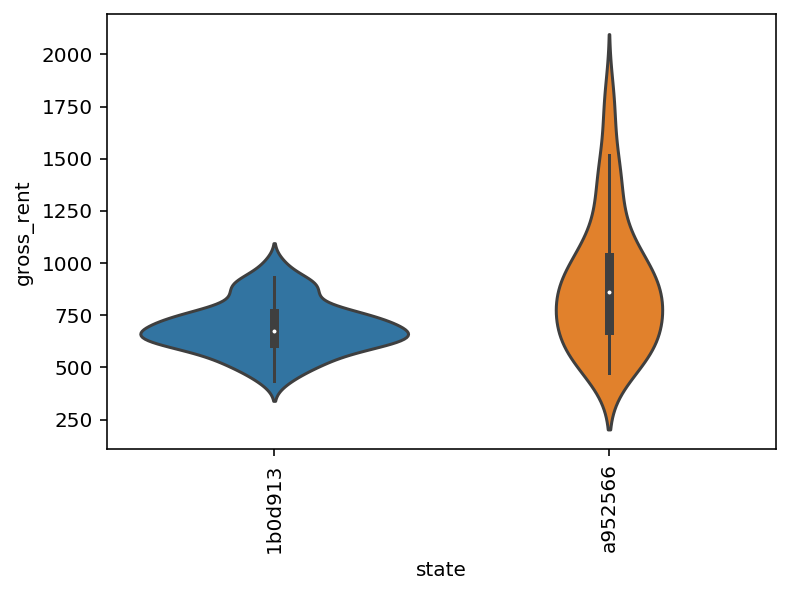

In [18]:
states=["1b0d913","a952566"]
plt.figure(var)
g=sns.violinplot(x="state", y='gross_rent', data=train.loc[train.state.isin(states)])
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.show

In [19]:
subset=train[["state","county_code","gross_rent"]]
subset=subset.groupby('state', as_index=False).agg({"county_code": "count","gross_rent" : "mean"})
subset.sort_values(['county_code'],ascending=False)

state  county_code   gross_rent
7   1b0d913          131   691.229008
14  4522abc           93   688.344086
36  a952566           69   894.710145
20  528ea9f           57   579.631579
41  c479f0c           56   650.535714
9   20d32fc           56   718.910714
0   08f8fb4           54   621.870370
43  dc9ae72           50   614.440000
32  9d1e27d           47   620.404255
1   09d8cd0           47   701.170213
38  b795815           45   585.266667
2   0f8930b           44   678.068182
45  e2f94fa           44   595.000000
25  7572db1           40   842.250000
33  9dda412           39   678.897436
31  9d0874a           39   623.000000
4   158df01           38   663.315789
8   1dcfd4e           37   866.054054
46  e74aca3           36   685.722222
28  8036085           35   599.685714
40  c3dbf0a           34   602.117647
26  78e8330           33   536.333333
34  9e0007d           33   605.151515
16  4c72956           31  1059.548387
21  52acab4           31   624.967742
47  e899d7f           31   607.612903
49  fb8cab1           30   577.900000
19  5086a32           28   847.571429
5   1646cf6           27   755.703704
29  842bd12           26   663.653846
15  485e9af           25   703.520000
23  698ab34           21   680.714286
17  4cd9667           20   701.800000
12  3745933           19   823.000000
27  7dd3518           18  1015.111111
6   176f5f0           16   761.312500
22  64ffe5d           15   744.200000
42  d233cec           10   730.900000
18  5029ed4            8   694.375000
39  bc77872            7  1227.428571
48  fa605d5            6   797.666667
44  dfc21f3            6  1031.000000
10  2b7da97            6   856.833333
37  b44cfe6            6  1159.000000
11  3337bbb            6  1027.500000
3   105e445            4  1032.250000
24  6d287d7            4   737.250000
13  375d4d3            2   795.000000
35  9e065a4            1   974.000000
30  914c15f            1  1569.000000

Data preparation and preprocessing

In [20]:
train_val.drop(columns=["county_code","homicides_per_100k"],inplace=True)
train_val.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1562 entries, 0 to 1561
Data columns (total 42 columns):
state                                         1562 non-null object
population                                    1562 non-null float64
renter_occupied_households                    1562 non-null float64
pct_renter_occupied                           1562 non-null float64
evictions                                     1235 non-null float64
rent_burden                                   1562 non-null float64
pct_white                                     1562 non-null float64
pct_af_am                                     1562 non-null float64
pct_hispanic                                  1562 non-null float64
pct_am_ind                                    1562 non-null float64
pct_asian                                     1562 non-null float64
pct_nh_pi                                     1562 non-null float64
pct_multiple                                  1562 non-null float64
pct_other 

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder

numeric_features = list(train_val.select_dtypes(include='number').columns.values)
print(numeric_features)
numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer()),
    ('scaler', RobustScaler())])

categorical_features = list(train_val.select_dtypes(exclude='number').columns.values)
print(categorical_features)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

preprocessor.fit(train_val)
X=preprocessor.transform(train_val)
print(X.shape)
y=np.array(train_lab['gross_rent'])
#y=np.log(y)
print(y.shape)

list_of_feat=numeric_features+categorical_features

['population', 'renter_occupied_households', 'pct_renter_occupied', 'evictions', 'rent_burden', 'pct_white', 'pct_af_am', 'pct_hispanic', 'pct_am_ind', 'pct_asian', 'pct_nh_pi', 'pct_multiple', 'pct_other', 'poverty_rate', 'pct_civilian_labor', 'pct_unemployment', 'pct_uninsured_adults', 'pct_uninsured_children', 'pct_adult_obesity', 'pct_adult_smoking', 'pct_diabetes', 'pct_low_birthweight', 'pct_excessive_drinking', 'pct_physical_inactivity', 'air_pollution_particulate_matter_value', 'motor_vehicle_crash_deaths_per_100k', 'heart_disease_mortality_per_100k', 'pop_per_dentist', 'pop_per_primary_care_physician', 'pct_female', 'pct_below_18_years_of_age', 'pct_aged_65_years_and_older', 'pct_adults_less_than_a_high_school_diploma', 'pct_adults_with_high_school_diploma', 'pct_adults_with_some_college', 'pct_adults_bachelors_or_higher', 'birth_rate_per_1k', 'death_rate_per_1k']
['state', 'rucc', 'urban_influence', 'economic_typology']


(1562, 115)
(1562,)


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, shuffle=True)

Model training and evaluation

In [23]:
from sklearn.linear_model import ElasticNetCV,MultiTaskElasticNetCV, RANSACRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf

ElNCv = ElasticNetCV(cv=5)
MtElNCv = MultiTaskElasticNetCV(cv=3)
AdaTreeReg=AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=1234)
AdaForReg=AdaBoostRegressor(RandomForestRegressor(oob_score=True), random_state=1234)
gbr_params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
gbr = GradientBoostingRegressor(**gbr_params)


In [24]:
ElNCv.fit(X_train, y_train)
#MtElNCv.fit(X_train, y_train)
AdaTreeReg.fit(X_train, y_train)
AdaForReg.fit(X_train, y_train)
gbr.fit(X_train, y_train)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2 score for ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0) is 0.6904129094076596
ElasticNetCV vs real.png


/ext/anaconda-2019.03/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


R2 score for AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=4,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=1.0, loss='linear', n_estimators=300,
            

/ext/anaconda-2019.03/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


R2 score for AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True,
                                                       criterion='mse',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators='warn',
                                                       n_jobs=None,
                                                       oob_score=True,
        

/ext/anaconda-2019.03/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


R2 score for GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) is 0.8230786969230469
GradientBoostingRegressor vs real.png


/ext/anaconda-2019.03/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


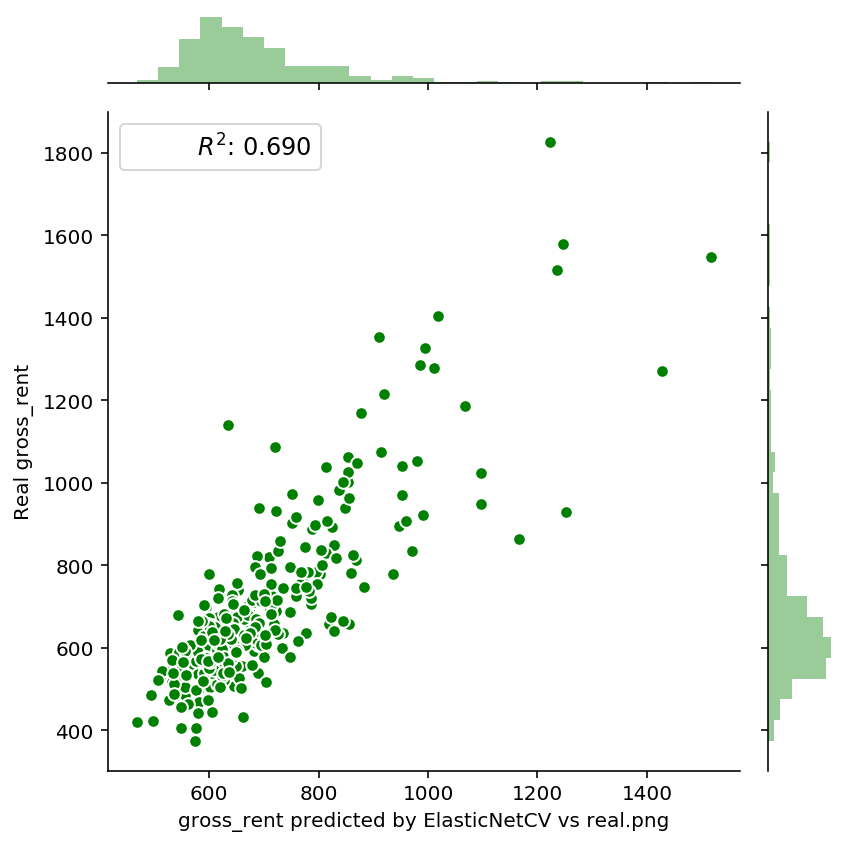

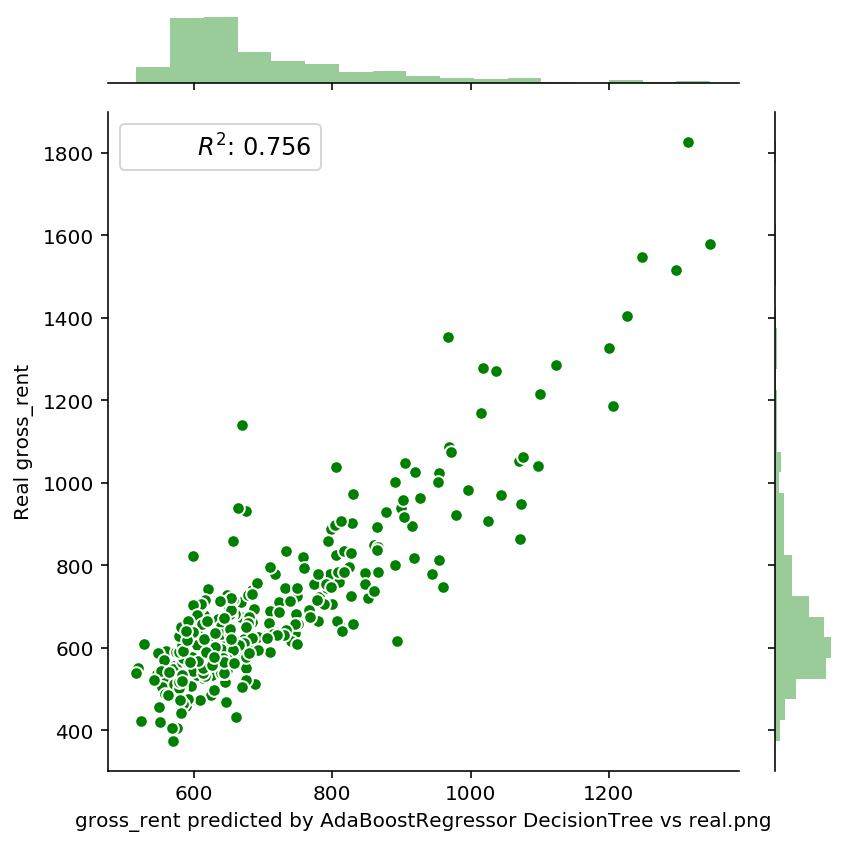

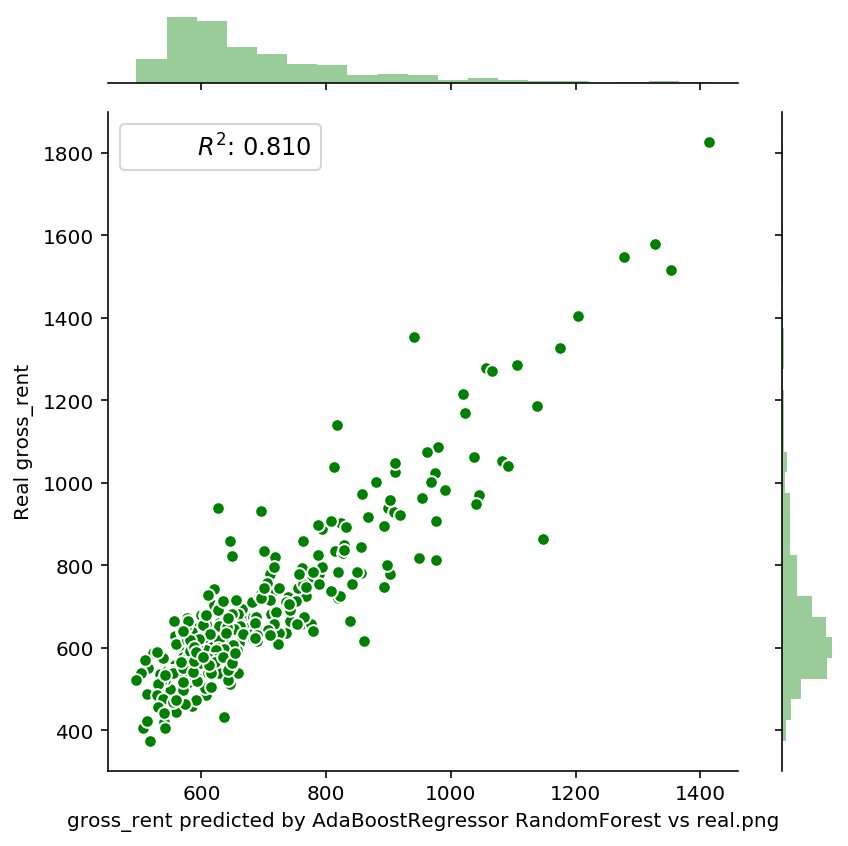

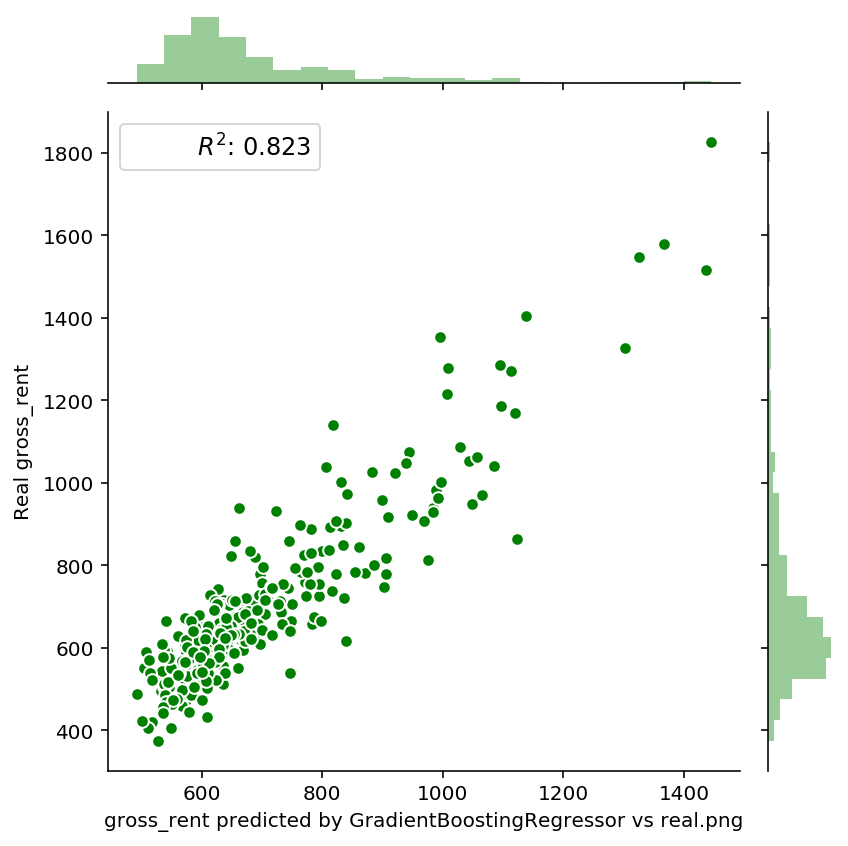

In [25]:
from sklearn.metrics import r2_score

reg_models_eval=Path.cwd()/"reg_models_eval"
try:
    reg_models_eval.mkdir()
except:
    FileExistsError

save_reg_models_eval=True

models=[ElNCv,AdaTreeReg,AdaForReg,gbr]

for model in models:
    y_pred=model.predict(X_test)
    r2=r2_score(y_test, y_pred)
    print("R2 score for "+str(model)+" is "+ str(r2))
    model_name=str(model)[:str(model).find('(')]
    estimator=[str(model).find('base_estimator='),str(model).find(',')] if 'base_estimator=' in str(model) else ''
    estimator=str(model)[estimator[0]:estimator[1]] if type(estimator)==list else ''
    estimator=' '+estimator.replace('base_estimator=', '') if 'base_estimator=' in str(model) else ''
    estimator=estimator[:estimator.find('Regressor(')]
    model_name=model_name+estimator+" vs real.png"
    print(model_name)
    g = sns.JointGrid(x=y_pred, y=y_test, height=6, ratio=7, space=0.1)
    g.plot_joint(plt.scatter,color="g", s=40, edgecolor="white")
    g.plot_marginals(sns.distplot, kde=False, color="g")
    rsquare = lambda a, b: r2
    g.annotate(rsquare, template="{stat}: {val:.3f}",
    stat="$R^2$", loc="upper left", fontsize=12)
    g.set_axis_labels('gross_rent predicted by '+model_name,'Real gross_rent')
    plt.autoscale()
    plt.tight_layout()
    plt.savefig(reg_models_eval/model_name, format='png',transparent=True,dpi=300) if save_reg_models_eval==True else None
    plt.show


In [26]:
test_val_2=test_val[[*list_of_feat]]
test_val_2.info(verbose=True)
preproc_test=preprocessor.transform(test_val_2)
print(preproc_test.shape)
print(preproc_test)
test_pred=gbr.predict(preproc_test)
test_pred=np.rint(test_pred)
test_pred.astype("int")


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1576 entries, 0 to 1575
Data columns (total 42 columns):
population                                    1576 non-null float64
renter_occupied_households                    1576 non-null float64
pct_renter_occupied                           1576 non-null float64
evictions                                     1263 non-null float64
rent_burden                                   1576 non-null float64
pct_white                                     1576 non-null float64
pct_af_am                                     1576 non-null float64
pct_hispanic                                  1576 non-null float64
pct_am_ind                                    1576 non-null float64
pct_asian                                     1576 non-null float64
pct_nh_pi                                     1576 non-null float64
pct_multiple                                  1576 non-null float64
pct_other                                     1576 non-null float64
poverty_r

array([640, 972, 724, ..., 994, 658, 570])

In [27]:
print(test_pred)
print(test_pred.shape)

[640. 972. 724. ... 994. 658. 570.]
(1576,)


In [43]:
save_predictions=True
np.savetxt('gbr_pred'+'.csv', test_pred, delimiter=",") if save_predictions==True else print('Predictions not saved')

Model's feature analysis

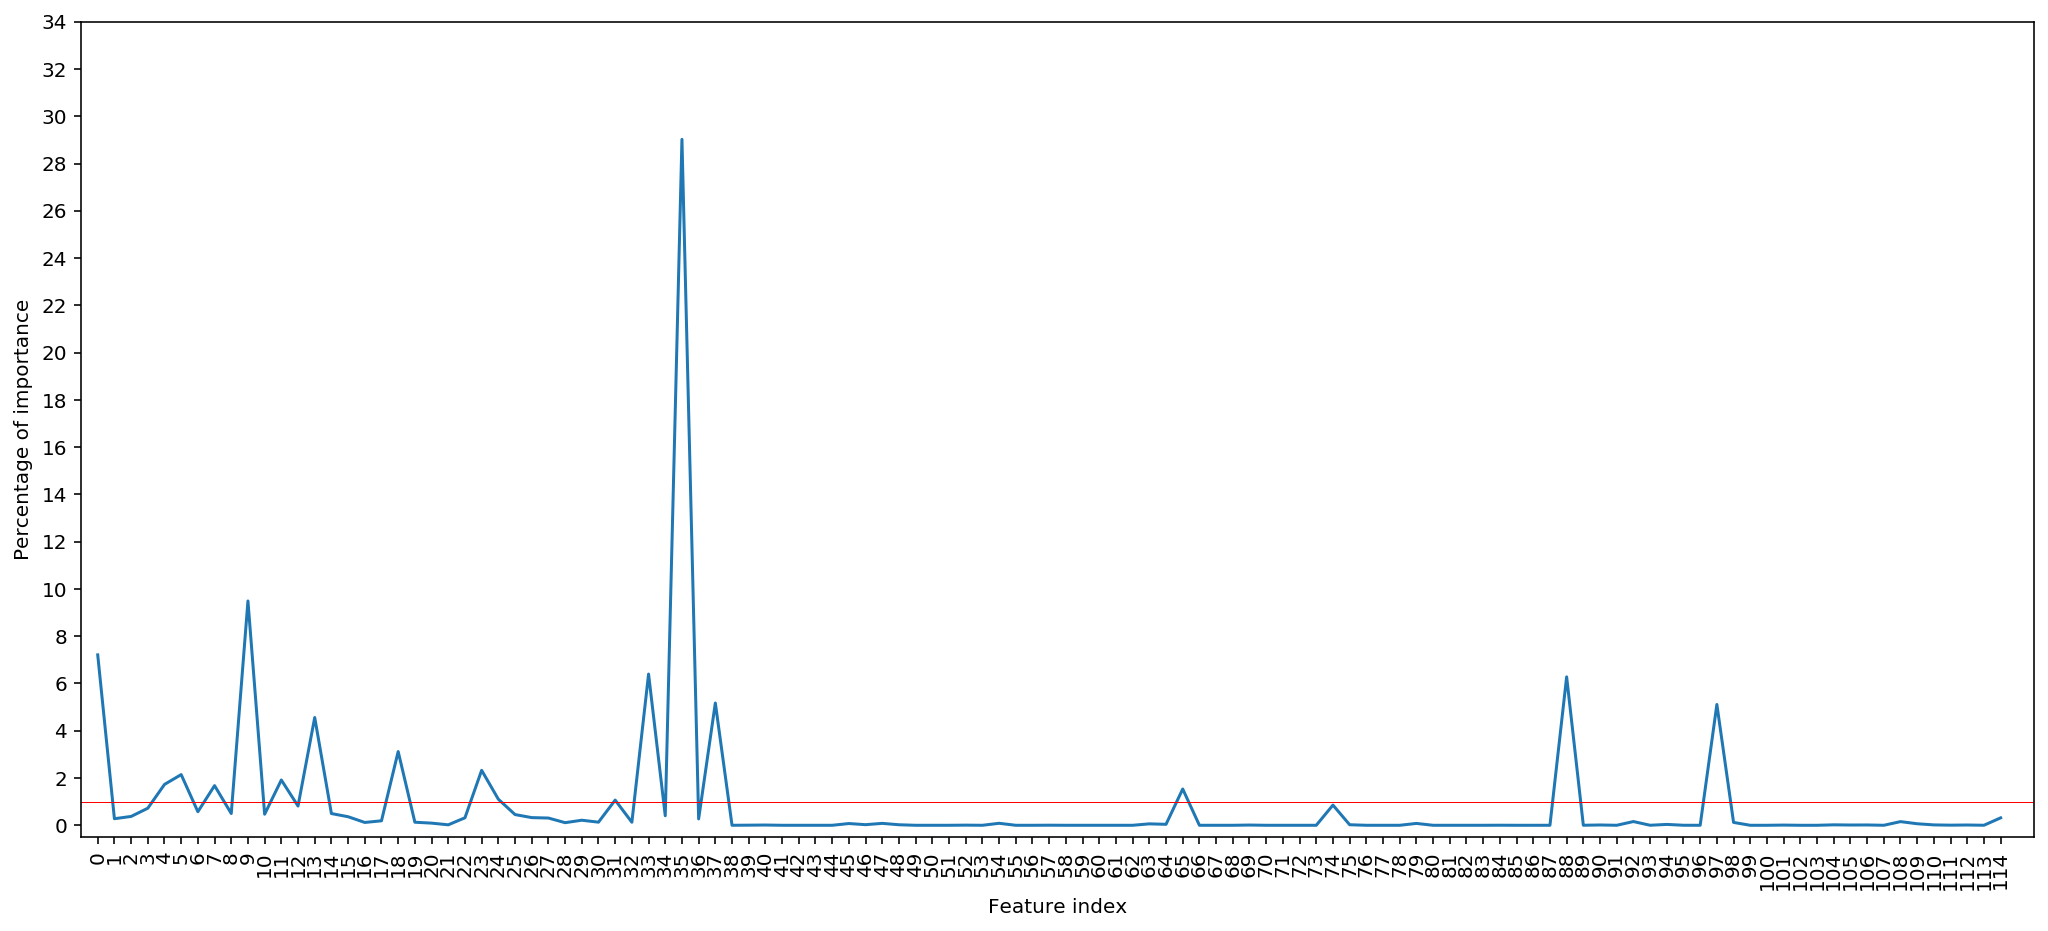

1.0000000000000002
0.847331008014637
0.08583783688549214


In [29]:
feat_imp=gbr.feature_importances_

feat_imp_fig=Path.cwd()/"feat_imp_fig"
try:
    feat_imp_fig.mkdir()
except:
    FileExistsError

save_feat_importance_fig=False

with PdfPages(feat_imp_fig/'feature_importances.pdf') as pdf_pages:
    fig=plt.figure(figsize=(17.5,7.5))
    plt.plot(feat_imp*100)
    plt.xlim(-1,116)
    plt.ylim(-0.5, 23)
    plt.yticks(np.arange(0, 35, step=2))
    plt.xticks(np.arange(0, 115, step=1),rotation=90)
    plt.ylabel("Percentage of importance")
    plt.xlabel("Feature index")
    plt.axhline(y=1,linewidth=0.5, color='r')
    pdf_pages.savefig(fig)# if save_feat_importance_fig==True else None
    plt.show()

print(sum(feat_imp))
print(sum(feat_imp[0:len(numeric_features)]))
print(sum(feat_imp[0:len(categorical_features)]))

Optimal number of features : 56


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


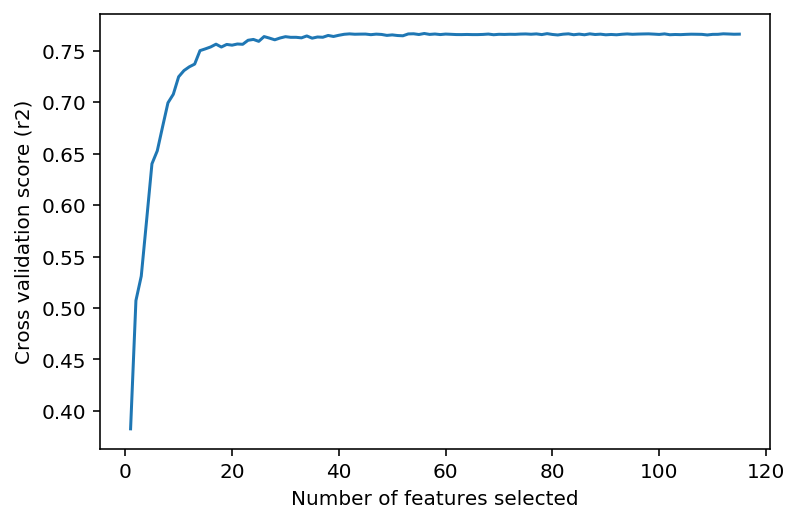

['population', 'renter_occupied_households', 'pct_renter_occupied', 'evictions', 'rent_burden', 'pct_white', 'pct_af_am', 'pct_hispanic', 'pct_am_ind', 'pct_asian', 'pct_nh_pi', 'pct_multiple', 'pct_other', 'poverty_rate', 'pct_civilian_labor', 'pct_unemployment', 'pct_uninsured_adults', 'pct_uninsured_children', 'pct_adult_obesity', 'pct_adult_smoking', 'pct_diabetes', 'pct_low_birthweight', 'pct_excessive_drinking', 'pct_physical_inactivity', 'air_pollution_particulate_matter_value', 'motor_vehicle_crash_deaths_per_100k', 'heart_disease_mortality_per_100k', 'pop_per_dentist', 'pop_per_primary_care_physician', 'pct_female', 'pct_below_18_years_of_age', 'pct_aged_65_years_and_older', 'pct_adults_less_than_a_high_school_diploma', 'pct_adults_with_high_school_diploma', 'pct_adults_with_some_college', 'pct_adults_bachelors_or_higher', 'birth_rate_per_1k', 'death_rate_per_1k', 'state_08f8fb4', 'state_09d8cd0', 'state_0f8930b', 'state_105e445', 'state_158df01', 'state_1646cf6', 'state_176f5

In [30]:
from sklearn.feature_selection import RFECV
from sklearn.externals import joblib

recursive_feature_elimination_through_cross_validation=False
if recursive_feature_elimination_through_cross_validation==True:
    rfecv = RFECV(estimator=gbr, step=1,
                  scoring='r2')
    rfecv.fit(X_train, y_train)
    joblib.dump(rfecv, 'rfecv_model_'+date.isoformat(date.today()))
else:
    rfecv=joblib.load('rfecv_model_2019-12-29')

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (r2)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


model_features_names=numeric_features+list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names(categorical_features))
print(model_features_names)
feature_analysis=pd.DataFrame([model_features_names,feat_imp*100,rfecv.support_])
feature_analysis=feature_analysis.T
feature_analysis.rename(columns={0:'Name', 1:"Importance",2:"rfecv_mask"}, inplace=True)

In [31]:
feature_analysis.head()

Name Importance rfecv_mask
0                  population    7.21009       True
1  renter_occupied_households    0.27812       True
2         pct_renter_occupied   0.373812       True
3                   evictions   0.721761       True
4                 rent_burden     1.7283       True

In [32]:
save_feature_analysis=False
save_feature_analysis=feature_analysis.to_csv("feature_analysis.csv", sep=",") if save_feature_analysis==True else False


Model refinement by feature selection and hyperparameters tuning

In [33]:
feature_selection=feature_analysis["Name"][feature_analysis.rfecv_mask==True]

In [34]:
len(feature_selection)

56

In [35]:
feature_selection=set(feature_selection)
print(feature_selection)
num_feat_2=set(numeric_features)
num_feat_2=set(numeric_features).intersection(feature_selection)
print(num_feat_2, len(num_feat_2))
cat_feat_2=set(categorical_features)
cat_feat_2=set(model_features_names).intersection(feature_selection)
print(cat_feat_2,len(cat_feat_2))

{'population', 'rucc_Nonmetro - Urban population of 2,500 to 19,999, not adjacent to a metro area', 'economic_typology_Federal/State government-dependent', 'pct_uninsured_adults', 'pct_adults_with_some_college', 'air_pollution_particulate_matter_value', 'state_4c72956', 'pct_civilian_labor', 'pct_physical_inactivity', 'rucc_Metro - Counties in metro areas of 1 million population or more', 'rucc_Nonmetro - Completely rural or less than 2,500 urban population, not adjacent to a metro area', 'pct_am_ind', 'pct_adults_with_high_school_diploma', 'pct_female', 'state_a952566', 'pct_multiple', 'poverty_rate', 'pct_excessive_drinking', 'death_rate_per_1k', 'rent_burden', 'state_20d32fc', 'pct_renter_occupied', 'pct_adults_bachelors_or_higher', 'pct_hispanic', 'heart_disease_mortality_per_100k', 'economic_typology_Farm-dependent', 'pct_white', 'urban_influence_Small-in a metro area with fewer than 1 million residents', 'state_c479f0c', 'pct_adult_smoking', 'birth_rate_per_1k', 'pct_nh_pi', 'pct

In [36]:
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_feat_2),
        ('cat', categorical_transformer, cat_feat_2)])

preprocessor.fit(train_val)
X_2=preprocessor.transform(train_val)

In [37]:
X_2_train, X_2_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, shuffle=True)

In [38]:
ElNCv_2 = ElasticNetCV(cv=5)
MtElNCv_2 = MultiTaskElasticNetCV(cv=3)
AdaTreeReg_2=AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=1234)
AdaForReg_2=AdaBoostRegressor(RandomForestRegressor(oob_score=True), random_state=1234)
gbr_params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
gbr_2 = GradientBoostingRegressor(**gbr_params)

In [39]:
ElNCv_2.fit(X_2_train, y_train)
#MtElNCv.fit(X_train, y_train)
AdaTreeReg_2.fit(X_2_train, y_train)
AdaForReg_2.fit(X_2_train, y_train)
gbr_2.fit(X_2_train, y_train)

/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/ext/anaconda-2019.03/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

retrain=False

parameters = {'loss':['ls', 'lad'],
              'n_estimators':[500,1000,2000],
              'max_depth': [2,4,8],
              'min_samples_split':[2,4,8],
              'max_depth':[3,6,9],
              'learning_rate': [0.001,0.01,0.1]}
if retrain==True:
    csgbr = GridSearchCV(gbr, parameters)
    csgbr.fit(X_2_train, y_train)

    joblib.dump(csgbr, 'tuned_gbr_'+date.isoformat(date.today()))
else:
    csgbr=joblib.load('tuned_gbr_271219')

In [41]:
csgbr

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.01,
                                                 loss='ls', max_depth=4,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=500,...
                                                 presort='auto',
              

R2 score for ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0) is 0.6904129094076596
ElasticNetCV


/ext/anaconda-2019.03/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


R2 score for AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=4,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=1.0, loss='linear', n_estimators=300,
            

/ext/anaconda-2019.03/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


R2 score for AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True,
                                                       criterion='mse',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators='warn',
                                                       n_jobs=None,
                                                       oob_score=True,
        

/ext/anaconda-2019.03/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


R2 score for GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) is 0.8237242998712603
GradientBoostingRegressor


/ext/anaconda-2019.03/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


R2 score for GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='lad', max_depth=9,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=8,
                          min_weight_fraction_leaf=0.0, n_estimators=2000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) is 0.8220827146776702
GradientBoostingRegressor


/ext/anaconda-2019.03/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


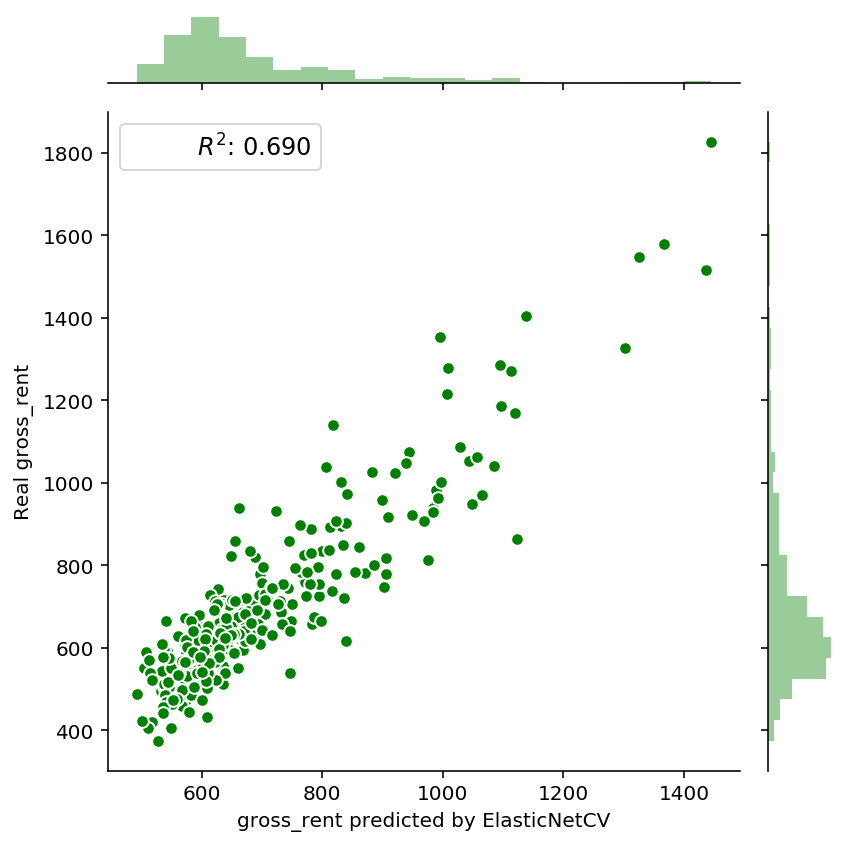

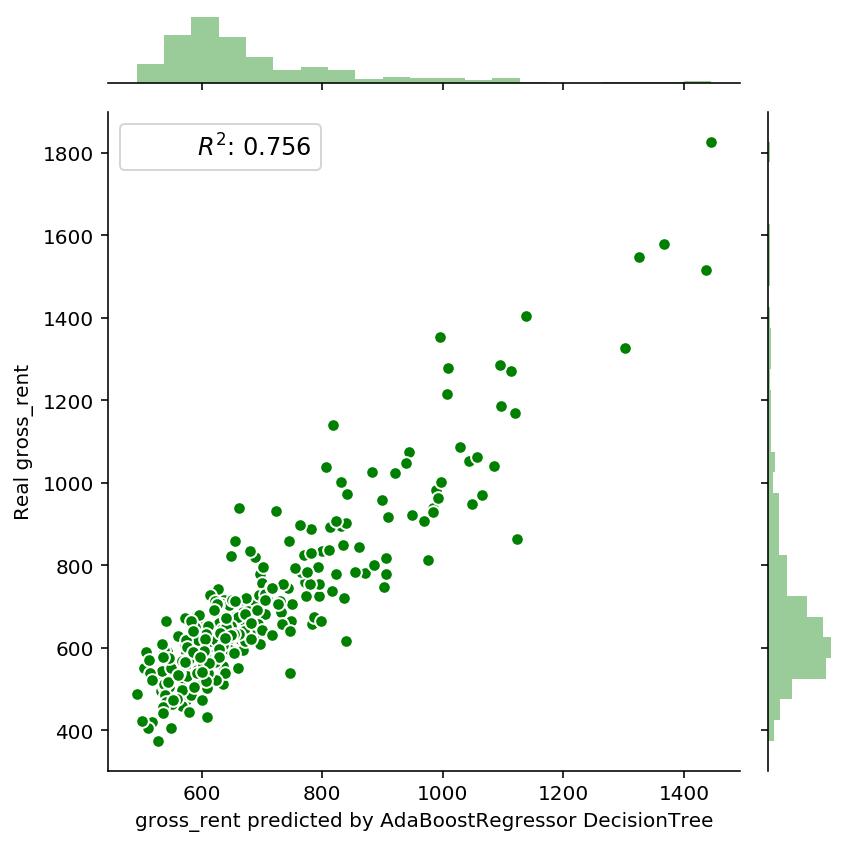

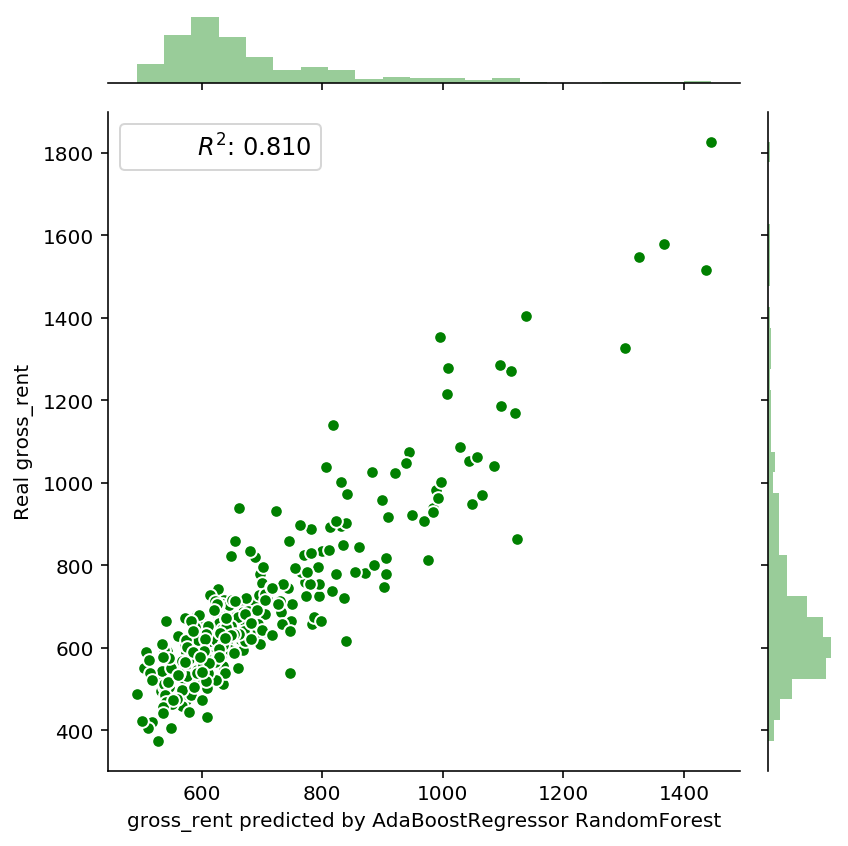

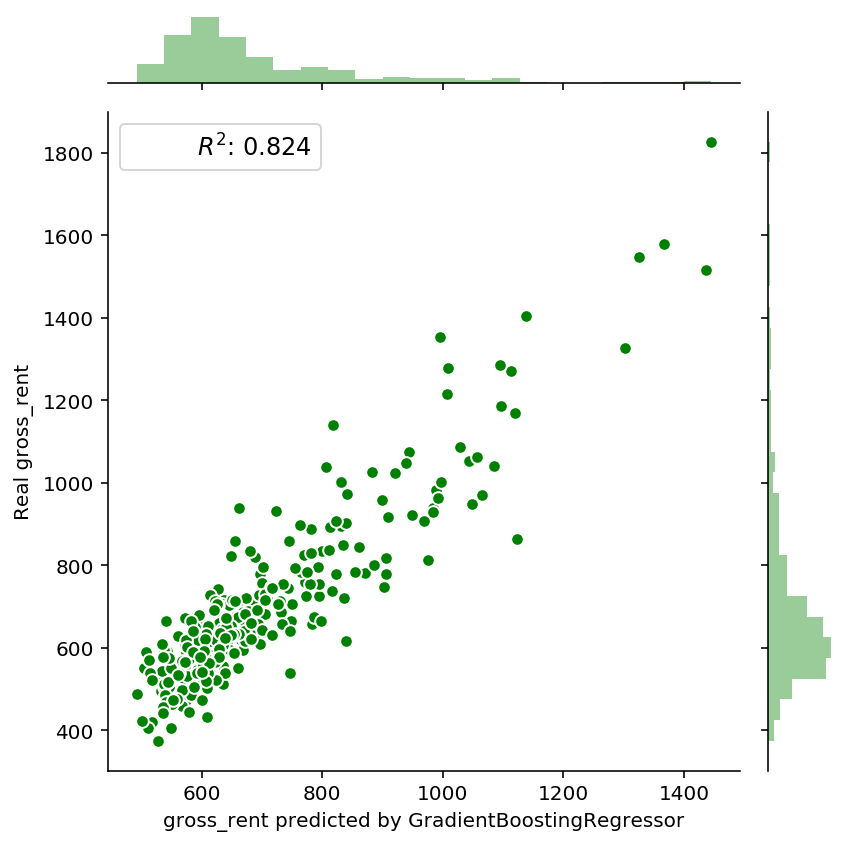

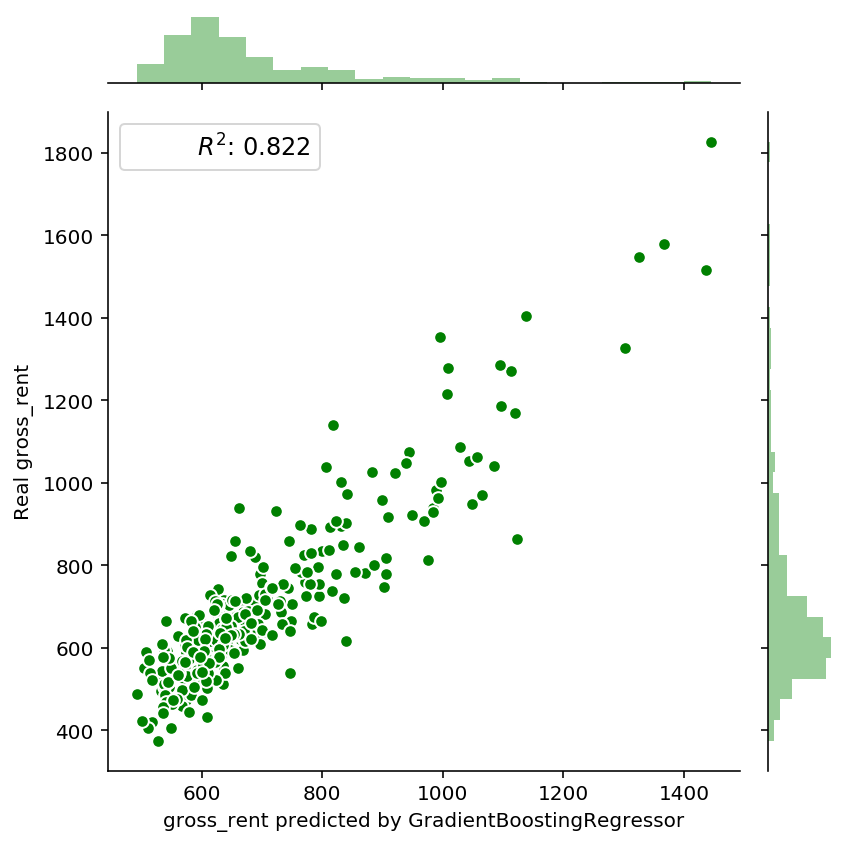

In [42]:
models=[ElNCv_2, AdaTreeReg_2,AdaForReg_2,gbr_2,csgbr.best_estimator_]

for model in models:
    y_2_pred=model.predict(X_2_test)
    r2=r2_score(y_test, y_2_pred)
    print("R2 score for "+str(model)+" is "+ str(r2))
    model_name=str(model)[:str(model).find('(')]
    estimator=[str(model).find('base_estimator='),str(model).find(',')] if 'base_estimator=' in str(model) else ''
    estimator=str(model)[estimator[0]:estimator[1]] if type(estimator)==list else ''
    estimator=' '+estimator.replace('base_estimator=', '') if 'base_estimator=' in str(model) else ''
    estimator=estimator[:estimator.find('Regressor(')]
    model_name=model_name+estimator
    print(model_name)
    g = sns.JointGrid(x=y_pred, y=y_test, height=6, ratio=7, space=0.1)
    g.plot_joint(plt.scatter,color="g", s=40, edgecolor="white")
    g.plot_marginals(sns.distplot, kde=False, color="g")
    rsquare = lambda a, b: r2
    g.annotate(rsquare, template="{stat}: {val:.3f}",
    stat="$R^2$", loc="upper left", fontsize=12)
    g.set_axis_labels('gross_rent predicted by '+model_name,'Real gross_rent')
    plt.autoscale()
    plt.tight_layout()
    plt.savefig(model_name+" vs real.png", format='png')
    plt.show